# Predict loanword and native verb use
Let's test media consumption as a variable for predicting loanword integration, while controlling for other author social variables (location, language use).

# Table of contents

1. Simple models
    1. [Predict loanword integration: first pass](#First-pass:-predict-loanword-use)
    2. [Normalize scalar vars](#Normalize-scalar-vars)
    3. [Predict native verb integration: first pass](#First-pass:-predict-native-verb-use)
    4. [Fixed effects: word](#Add-fixed-effects-for-word-type)
    5. [Interaction](#Add-fixed-effect-and-interaction)
    6. [Fixed effects: author + word](#Add-fixed-effects-for-authors-and-words)
2. Fancy models
    1. [Fixed effects: elastic net](#Add-fixed-effects-for-words-and-authors:-elastic-net-regression)
    2. [Predict with fewer vars](#Predict-with-language,-location,-fixed-effects)
    3. [Conditional logit](#Add-fixed-effects-for-authors:-conditional-logit)
    4. [Two-stage regression](#Add-fixed-effects-for-authors:-two-stage-regression)
    5. [Filter on media sharing](#Predict-loanword-and-native-word-use:-filter-on-media-sharing)
    6. [Predict with media balanced data](#Predict-using-media-balanced-data)
    7. [Predict with "extreme" authors](#Predict-with-author-subset:-highly-active-authors)

In [209]:
import pandas as pd
loanword_social_data = pd.read_csv('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', sep='\t')
native_verb_social_data = pd.read_csv('../../data/mined_tweets/native_verb_use_author_social_data.tsv', sep='\t')

In [2]:
import numpy as np
def bin_data_var(data, bin_ranges, bin_names, bin_var='es'):
    bin_vals = list(map(bin_names.get, np.digitize(data.loc[:, bin_var], bin_ranges)))
    data = data.assign(**{
        f'{bin_var}_bin' : bin_vals
    })
    return data
# bin lang use
bin_ranges = [0.25, 0.75]
bin_names = {0 : 'es_low', 1 : 'es_mid', 2 : 'es_high'}
lang_var = 'es'
loanword_social_data = bin_data_var(loanword_social_data, bin_ranges, bin_names, bin_var=lang_var)
native_verb_social_data = bin_data_var(native_verb_social_data, bin_ranges, bin_names, bin_var=lang_var)
# bin media sharing
bin_range = [0.1, 0.5]
bin_names = {0 : 'media_low', 1 : 'media_mid', 2 : 'media_high'}
media_var = 'latin_american_media_pct'
loanword_social_data = bin_data_var(loanword_social_data, bin_ranges, bin_names, bin_var=media_var)
native_verb_social_data = bin_data_var(native_verb_social_data, bin_ranges, bin_names, bin_var=media_var)

In [3]:
# cleanup
loanword_social_data.fillna('', inplace=True)
native_verb_social_data.fillna('', inplace=True)

How many authors have all social attributes?

In [4]:
def filter_valid_data(data, 
                      social_vars=['es_bin', 'latin_american_media_pct', 'description_location_region', 'integrated_verb_pct'],
                      scalar_vars = ['latin_american_media_pct', 'integrated_verb_pct']):
    valid_data = data.copy()
    for social_var in social_vars:
        valid_data = valid_data[valid_data.loc[:, social_var] != '']
    # fix scalar vars
    for scalar_var in scalar_vars:
        valid_data = valid_data.assign(**{
            scalar_var : valid_data.loc[:, scalar_var].astype(float)
        })
    return valid_data
valid_loanword_social_data = filter_valid_data(loanword_social_data)
valid_native_verb_social_data = filter_valid_data(native_verb_social_data)
display(valid_loanword_social_data.head())
display(valid_native_verb_social_data.head())

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,loanword,loanword_verb,loanword_type,screen_name,user_id,text,date,id,user_description,user_location,...,latin_american_artist_video_pct,total_music_count,latin_american_music_genre_pct,latin_american_music_genre_count,us_american_music_genre_count,latin_american_media_count,us_american_media_count,latin_american_media_pct,integrated_verb_pct,latin_american_media_pct_bin
67,ban,baneo,integrated_loanword,julianhckr,760320658546929665,@diego_mehary Mod menú de USB Jajajajaja direc...,,892836052490227717,ROAD TO 2.5K SUBS xD YOUTUBE CHANNEL🔴 [JULIANHCK],"Medellín, Colombia",...,0,,,,,0,4,0.0,1.000000,media_low
142,ban,banea,integrated_loanword,alexdeleo97,1362786452,@MrRodricebrix Eso demuestra que hay mucho gil...,,884053288945152000,Platino III Main Alistar | 19 fucking años y o...,"Valdebronx, Madrid.",...,0,,,,,0,1,0.0,0.909091,media_low
166,audit,auditar,integrated_loanword,yerardjimenez,1339395775,La Cámara de Cuentas debe auditar la Universid...,,889848810477944832,"Ataráxico // Advertiser, amateur writer, bloge...",República Dominicana,...,0.5,,,,,1,1,0.5,0.904167,media_mid
167,audit,auditar,integrated_loanword,lagranciudad,29059474,Héctor Rodríguez: No tenemos problemas en audi...,,893520340604903426,Somos una mezcla de medios con información de ...,"ÜT: 10.206182,-66.838661",...,1,,,,,1,0,1.0,1.000000,media_high
175,audit,auditar,integrated_loanword,fermosan_tires,190513736,@mmerloj Entonces el contralor Celi puede audi...,,897848606492954624,Creo en el trabajo y el sacrificio diario. Dio...,"Salitre, Ecuador",...,,2,0,0,0,0,0,0.0,0.900000,media_low


,screen_name,id,date,text,native_word_category,native_word_type,description_location_region,es,latin_american_artist_video_pct,latin_american_music_genre_pct,latin_american_media_pct,integrated_verb_pct,es_bin,latin_american_media_pct_bin
463,13littlemonkey,1132702179997999105,2019-05-26 13:36:58,Paulista cuando se retire que se dedique a ani...,native_integrated_verb,animar,europe,0.916779,0,,0.0,1.0,es_high,media_low
464,13littlemonkey,1117518454154760192,2019-04-14 16:02:16,Y POR ESO LO COMPRAMOS,native_integrated_verb,comprar,europe,0.916779,0,,0.0,1.0,es_high,media_low
465,13littlemonkey,1108163250288582658,2019-03-19 20:28:02,Un beso y un abrazo a todas las valencianas y ...,native_integrated_verb,decidir,europe,0.916779,0,,0.0,1.0,es_high,media_low
466,13littlemonkey,1094221018091216897,2019-02-09 08:06:35,Alba fuera de España: Sara Bareilles y Zaz la ...,native_integrated_verb,admirar,europe,0.916779,0,,0.0,1.0,es_high,media_low
467,13littlemonkey,1075533796928303110,2018-12-19 18:30:14,No puedo dejar de mirar a Sabela y Julia # OT1...,native_integrated_verb,mirar,europe,0.916779,0,,0.0,1.0,es_high,media_low


In [5]:
print('%d/%d authors with valid vars'%(valid_loanword_social_data.shape[0], loanword_social_data.shape[0]))

3275/87610 authors with valid vars


OK! Overall not a huge distribution of authors. Let's try to use all the data first and then simplify the variables as necessary.

In [6]:
# clean up vars
# dependent var
loanword_dep_var = 'loanword_type'
valid_loanword_social_data = valid_loanword_social_data.assign(**{
    'has_light_verb' : (valid_loanword_social_data.loc[:, loanword_dep_var]=='light_verb_loanword').astype(int)
})
native_verb_dep_var = 'native_word_category'
valid_native_verb_social_data = valid_native_verb_social_data.assign(**{
    'has_light_verb' : 1 - (valid_native_verb_social_data.loc[:, native_verb_dep_var]=='native_integrated_verb').astype(int)
})

In [7]:
binary_dep_var = 'has_light_verb'
print(valid_loanword_social_data.loc[:, binary_dep_var].value_counts())
print(valid_native_verb_social_data.loc[:, binary_dep_var].value_counts())

0    2217
1    1058
Name: has_light_verb, dtype: int64
0    59743
1     2758
Name: has_light_verb, dtype: int64


### First pass: predict loanword use

In [8]:
from statsmodels.discrete.discrete_model import Logit
binary_dep_var = 'has_light_verb'
media_var = 'latin_american_media_pct_bin'
native_verb_var = 'integrated_verb_pct'
scalar_vars = [native_verb_var]
lang_bin_var = 'es_bin'
loc_var = 'description_location_region'
cat_vars = [lang_bin_var, loc_var, media_var]
cat_var_treatment_vals = ['es_high', 'other', 'media_low']
scalar_var_str = ' + '.join(scalar_vars)
cat_var_str = ' + '.join(list(map(lambda x: 'C(%s, Treatment("%s"))'%(x[0], x[1]), zip(cat_vars, cat_var_treatment_vals))))
formula = f'{binary_dep_var} ~ {scalar_var_str} + {cat_var_str}'
model = Logit.from_formula(formula, data=valid_loanword_social_data)
fit_model = model.fit(method='bfgs', maxiter=200)
display(fit_model.summary())

/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.626147
         Iterations: 67
         Function evaluations: 68
         Gradient evaluations: 68


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         has_light_verb   No. Observations:                 3275
Model:                          Logit   Df Residuals:                     3266
Method:                           MLE   Df Model:                            8
Date:                Tue, 05 May 2020   Pseudo R-squ.:                0.004772
Time:                        00:34:08   Log-Likelihood:                -2050.6
converged:                       True   LL-Null:                       -2060.5
Covariance Type:            nonrobust   LLR p-value:                   0.01167
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                -0.8327      0.463     -1.797      0.072      -1.741       0.075
C(es_bin, Treatment("es_high"))[T.es_low]                                 0.8659      0.421      2.058      0.040       0.041       1.691
C(es_bin, Treatment("es_high"))[T.es_mid]                                 0.4356      0.128      3.412      0.001       0.185       0.686
C(description_location_region, Treatment("other"))[T.europe]              0.0406      0.141      0.287      0.774      -0.236       0.317
C(description_location_region, Treatment("other"))[T.latin_america]      -0.1094      0.084     -1.299      0.194      -0.275       0.056
C(description_location_region, Treatment("other"))[T.us_america]         -0.0826      0.236     -0.350      0.726      -0.545       0.380
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_high]     0.0110      0.100      0.110      0.912      -0.185       0.207
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_mid]     -0.1015      0.095     -1.067      0.286      -0.288       0.085
integrated_verb_pct                                                       0.1040      0.488      0.213      0.831      -0.853       1.061
=========================================================================================================================================
"""

In [9]:
pd.set_option('display.precision', 3)
from model_helpers import get_regression_output
fit_model_results = get_regression_output(fit_model)
display(fit_model_results)

,coeff,p,CI_low,CI_high
Intercept,-0.833,7.228e-02,-1.741,0.075
"C(es_bin, Treatment(""es_high""))[T.es_low]",0.866,3.959e-02,0.041,1.691
"C(es_bin, Treatment(""es_high""))[T.es_mid]",0.436,6.447e-04,0.185,0.686
"C(description_location_region, Treatment(""other""))[T.europe]",0.041,7.737e-01,-0.236,0.317
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.109,1.939e-01,-0.275,0.056
"C(description_location_region, Treatment(""other""))[T.us_america]",-0.083,7.264e-01,-0.545,0.380
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",0.011,9.123e-01,-0.185,0.207
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_mid]",-0.102,2.860e-01,-0.288,0.085
integrated_verb_pct,0.104,8.313e-01,-0.853,1.061


OK! No significant results when controlling for social variables except: 
- mid-range bilingual authors much more likely to use light verbs

### Normalize scalar vars
Some of the scalar variables are skewed. What are the results if we log-transform them?

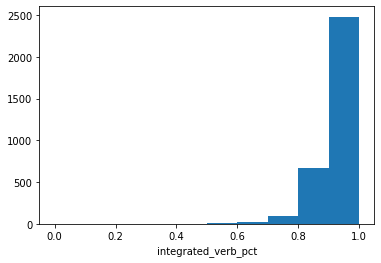

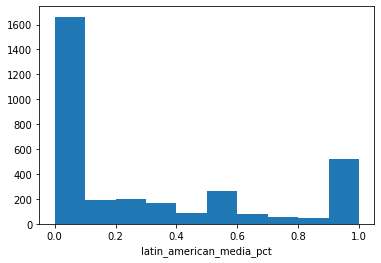

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


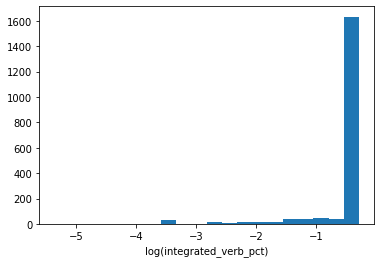

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


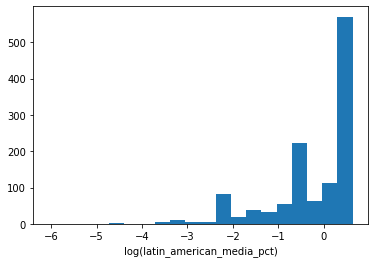

In [10]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# z-norm
from sklearn.preprocessing import StandardScaler
scalar_vars = ['integrated_verb_pct', 'latin_american_media_pct']
smooth_val = 1e-3
for scalar_var in scalar_vars:
    plt.hist(valid_loanword_social_data.loc[:, scalar_var])
    plt.xlabel(scalar_var)
    plt.show()
scaler = StandardScaler()
for scalar_var in scalar_vars:
    log_scalar_vals = np.log(scaler.fit_transform((valid_loanword_social_data.loc[:, scalar_var] + smooth_val).values.reshape(-1,1)))
    plt.hist(log_scalar_vals, bins=20)
    plt.xlabel('log(%s)'%(scalar_var))
    plt.show()

Still spiky but maybe better for the media sharing variable.

In [11]:
smooth_val = 1e-3
scaler = StandardScaler()
scalar_vars = ['integrated_verb_pct', 'latin_american_media_pct']
for scalar_var in scalar_vars:
    log_scalar_vals = scaler.fit_transform(np.log((valid_loanword_social_data.loc[:, scalar_var] + smooth_val).values.reshape(-1,1)))
    valid_loanword_social_data = valid_loanword_social_data.assign(**{
        f'log_{scalar_var}' : log_scalar_vals
    })

In [16]:
from statsmodels.discrete.discrete_model import Logit
binary_dep_var = 'has_light_verb'
media_var = 'latin_american_media_pct_bin'
# media_vars = ['log_latin_american_media_pct']
native_verb_var = 'log_integrated_verb_pct'
# scalar_vars = [native_verb_var] + media_vars
scalar_vars = [native_verb_var]
lang_bin_var = 'es_bin'
loc_var = 'description_location_region'
cat_vars = [lang_bin_var, loc_var, media_var]
cat_var_treatment_vals = ['es_high', 'other', 'media_low']
scalar_var_str = ' + '.join(scalar_vars)
cat_var_str = ' + '.join(list(map(lambda x: 'C(%s, Treatment("%s"))'%(x[0], x[1]), zip(cat_vars, cat_var_treatment_vals))))
formula = f'{binary_dep_var} ~ {scalar_var_str} + {cat_var_str}'
model = Logit.from_formula(formula, data=valid_loanword_social_data)
fit_model = model.fit(method='bfgs', maxiter=200)
display(fit_model.summary())

Optimization terminated successfully.
         Current function value: 0.626066
         Iterations: 57
         Function evaluations: 58
         Gradient evaluations: 58


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         has_light_verb   No. Observations:                 3275
Model:                          Logit   Df Residuals:                     3266
Method:                           MLE   Df Model:                            8
Date:                Tue, 05 May 2020   Pseudo R-squ.:                0.004901
Time:                        00:44:23   Log-Likelihood:                -2050.4
converged:                       True   LL-Null:                       -2060.5
Covariance Type:            nonrobust   LLR p-value:                  0.009614
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                -0.7344      0.060    -12.245      0.000      -0.852      -0.617
C(es_bin, Treatment("es_high"))[T.es_low]                                 0.8679      0.421      2.063      0.039       0.043       1.693
C(es_bin, Treatment("es_high"))[T.es_mid]                                 0.4326      0.128      3.385      0.001       0.182       0.683
C(description_location_region, Treatment("other"))[T.europe]              0.0285      0.141      0.201      0.840      -0.249       0.306
C(description_location_region, Treatment("other"))[T.latin_america]      -0.1080      0.084     -1.282      0.200      -0.273       0.057
C(description_location_region, Treatment("other"))[T.us_america]         -0.0743      0.236     -0.315      0.753      -0.537       0.388
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_high]     0.0119      0.100      0.119      0.905      -0.184       0.208
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_mid]     -0.1013      0.095     -1.065      0.287      -0.288       0.085
log_integrated_verb_pct                                                  -0.0282      0.039     -0.724      0.469      -0.104       0.048
=========================================================================================================================================
"""

In [18]:
display(get_regression_output(fit_model))

,coeff,p,CI_low,CI_high
Intercept,-0.734,1.786e-34,-0.852,-0.617
"C(es_bin, Treatment(""es_high""))[T.es_low]",0.868,3.913e-02,0.043,1.693
"C(es_bin, Treatment(""es_high""))[T.es_mid]",0.433,7.108e-04,0.182,0.683
"C(description_location_region, Treatment(""other""))[T.europe]",0.029,8.403e-01,-0.249,0.306
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.108,1.999e-01,-0.273,0.057
"C(description_location_region, Treatment(""other""))[T.us_america]",-0.074,7.527e-01,-0.537,0.388
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",0.012,9.049e-01,-0.184,0.208
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_mid]",-0.101,2.870e-01,-0.288,0.085
log_integrated_verb_pct,-0.028,4.690e-01,-0.104,0.048


Same results:

- mid-range bilingual authors much more likely to use light verbs
- Latin American authors slightly less likely to use light verbs

### First pass: predict native verb use

Do we see the same language effect with native verbs? I sure hope not!!

In [19]:
from statsmodels.discrete.discrete_model import Logit
binary_dep_var = 'has_light_verb'
media_var = 'latin_american_media_pct_bin'
# scalar_vars = [] + media_vars
lang_bin_var = 'es_bin'
loc_var = 'description_location_region'
cat_vars = [lang_bin_var, loc_var, media_var]
cat_var_treatment_vals = ['es_high', 'other', 'media_low']
# scalar_var_str = ' + '.join(scalar_vars)
cat_var_str = ' + '.join(list(map(lambda x: 'C(%s, Treatment("%s"))'%(x[0], x[1]), zip(cat_vars, cat_var_treatment_vals))))
# formula = f'{binary_dep_var} ~ {scalar_var_str} + {cat_var_str}'
formula = f'{binary_dep_var} ~ {cat_var_str}'
model = Logit.from_formula(formula, data=valid_native_verb_social_data)
fit_model = model.fit(method='bfgs', maxiter=200)
display(fit_model.summary())

Optimization terminated successfully.
         Current function value: 0.180514
         Iterations: 99
         Function evaluations: 100
         Gradient evaluations: 100


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         has_light_verb   No. Observations:                62501
Model:                          Logit   Df Residuals:                    62493
Method:                           MLE   Df Model:                            7
Date:                Tue, 05 May 2020   Pseudo R-squ.:                0.001837
Time:                        00:44:47   Log-Likelihood:                -11282.
converged:                       True   LL-Null:                       -11303.
Covariance Type:            nonrobust   LLR p-value:                 6.381e-07
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                -3.0580      0.027   -113.558      0.000      -3.111      -3.005
C(es_bin, Treatment("es_high"))[T.es_low]                                -1.2559      1.027     -1.223      0.222      -3.269       0.758
C(es_bin, Treatment("es_high"))[T.es_mid]                                -0.2774      0.108     -2.560      0.010      -0.490      -0.065
C(description_location_region, Treatment("other"))[T.europe]              0.3129      0.068      4.595      0.000       0.179       0.446
C(description_location_region, Treatment("other"))[T.latin_america]      -0.0763      0.043     -1.777      0.076      -0.160       0.008
C(description_location_region, Treatment("other"))[T.us_america]         -0.0276      0.130     -0.212      0.832      -0.283       0.228
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_high]    -0.5041      0.338     -1.489      0.136      -1.167       0.159
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_mid]     -0.0858      0.100     -0.857      0.392      -0.282       0.111
=========================================================================================================================================
"""

In [21]:
display(get_regression_output(fit_model))

,coeff,p,CI_low,CI_high
Intercept,-3.058,0.000e+00,-3.111,-3.005
"C(es_bin, Treatment(""es_high""))[T.es_low]",-1.256,2.215e-01,-3.269,0.758
"C(es_bin, Treatment(""es_high""))[T.es_mid]",-0.277,1.047e-02,-0.490,-0.065
"C(description_location_region, Treatment(""other""))[T.europe]",0.313,4.324e-06,0.179,0.446
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.076,7.551e-02,-0.160,0.008
"C(description_location_region, Treatment(""other""))[T.us_america]",-0.028,8.321e-01,-0.283,0.228
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",-0.504,1.364e-01,-1.167,0.159
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_mid]",-0.086,3.916e-01,-0.282,0.111


OK! We see different effects here:

- mid-range bilingual authors are only weakly less likely to use light verbs
- European authors are much more likely to use light verbs

This suggests that native verb constraints are different from loanword verb constraints.

### Add fixed effects for word type
Let's add some fixed effects for word type to start, since it's likely to be slightly more robust than the per-author effects.

Let's restrict the data to only include words with at least 5 occurrences.

In [22]:
def filter_data_by_type_count(data, type_var, min_type_count=5):
    type_counts = data.loc[:, type_var].value_counts()
    valid_types = type_counts[type_counts >= min_type_count].index.tolist()
    freq_data = data[data.loc[:, type_var].isin(valid_types)]
    return freq_data
min_word_count = 5
freq_loanword_social_data = filter_data_by_type_count(valid_loanword_social_data, 'loanword', min_type_count=min_word_count)
freq_native_verb_social_data = filter_data_by_type_count(valid_native_verb_social_data, 'native_word_type', min_type_count=min_word_count)

In [23]:
print('%d/%d freq loanword data'%(freq_loanword_social_data.shape[0], valid_loanword_social_data.shape[0]))
print('%d/%d freq native verb data'%(freq_native_verb_social_data.shape[0], valid_native_verb_social_data.shape[0]))

3234/3275 freq loanword data
62499/62501 freq native verb data


Loanwords first.

In [24]:
from statsmodels.discrete.discrete_model import Logit
binary_dep_var = 'has_light_verb'
# media_vars = ['latin_american_media_pct']
media_var = 'latin_american_media_pct_bin'
native_verb_var = 'integrated_verb_pct'
# scalar_vars = [native_verb_var] + media_vars
scalar_vars = [native_verb_var]
lang_bin_var = 'es_bin'
loc_var = 'description_location_region'
word_type_var = 'loanword'
# get default word type val: least frequent
default_word_type_val = freq_loanword_social_data.loc[:, word_type_var].value_counts().index[-1]
cat_vars = [lang_bin_var, loc_var, media_var, word_type_var]
cat_var_treatment_vals = ['es_high', 'other', 'media_low', default_word_type_val]
scalar_var_str = ' + '.join(scalar_vars)
cat_var_str = ' + '.join(list(map(lambda x: 'C(%s, Treatment("%s"))'%(x[0], x[1]), zip(cat_vars, cat_var_treatment_vals))))
formula = f'{binary_dep_var} ~ {scalar_var_str} + {cat_var_str}'
model = Logit.from_formula(formula, data=freq_loanword_social_data)
fit_model = model.fit(method='bfgs', maxiter=200)
display(fit_model.summary())
# remove all words
fit_model_output = get_regression_output(fit_model)
fit_model_output = fit_model_output.loc[list(filter(lambda x: 'loanword' not in x, fit_model_output.index)), :]
display(fit_model_output)

         Current function value: 0.296353
         Iterations: 200
         Function evaluations: 201
         Gradient evaluations: 201


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         has_light_verb   No. Observations:                 3234
Model:                          Logit   Df Residuals:                     3154
Method:                           MLE   Df Model:                           79
Date:                Tue, 05 May 2020   Pseudo R-squ.:                  0.5280
Time:                        00:45:35   Log-Likelihood:                -958.41
converged:                      False   LL-Null:                       -2030.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                -3.3271      2.158     -1.541      0.123      -7.557       0.903
C(es_bin, Treatment("es_high"))[T.es_low]                                 0.3059      0.668      0.458      0.647      -1.003       1.614
C(es_bin, Treatment("es_high"))[T.es_mid]                                 0.2638      0.194      1.361      0.174      -0.116       0.644
C(description_location_region, Treatment("other"))[T.europe]              0.6345      0.231      2.747      0.006       0.182       1.087
C(description_location_region, Treatment("other"))[T.latin_america]      -0.2637      0.128     -2.054      0.040      -0.515      -0.012
C(description_location_region, Treatment("other"))[T.us_america]          0.3728      0.430      0.868      0.385      -0.469       1.215
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_high]     0.3434      0.159      2.166      0.030       0.033       0.654
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_mid]      0.0326      0.143      0.228      0.820      -0.248       0.313
C(loanword, Treatment("draft"))[T.DM]                                    13.0583     14.257      0.916      0.360     -14.884      41.001
C(loanword, Treatment("draft"))[T.access]                                 2.9219      2.095      1.395      0.163      -1.184       7.028
C(loanword, Treatment("draft"))[T.audit]                                 -4.8377     14.999     -0.323      0.747     -34.235      24.559
C(loanword, Treatment("draft"))[T.ban]                                   -0.5190      2.301     -0.226      0.822      -5.029       3.991
C(loanword, Treatment("draft"))[T.block]                                  5.3744      2.109      2.548      0.011       1.240       9.508
C(loanword, Treatment("draft"))[T.box]                                    2.6666      2.170      1.229      0.219      -1.587       6.920
C(loanword, Treatment("draft"))[T.boycott]                                3.2285      2.055      1.571      0.116      -0.800       7.257
C(loanword, Treatment("draft"))[T.bully]                                  3.8188      2.113      1.807      0.071      -0.323       7.961
C(loanword, Treatment("draft"))[T.cast]                                   3.3379      2.064      1.617      0.106      -0.708       7.384
C(loanword, Treatment("draft"))[T.chat]                                   2.4403      2.067      1.181      0.238      -1.610       6.491
C(loanword, Treatment("draft"))[T.check]                                  1.2821      2.089      0.614      0.539      -2.811       5.376
C(loanword, Treatment("draft"))[T.connect]                               -0.2370      2.103     -0.113      0.910      -4.358       3.884
C(loanword, Treatment("draft"))[T.crack]                           

,coeff,p,CI_low,CI_high
Intercept,-3.327,0.123,-7.557,0.903
"C(es_bin, Treatment(""es_high""))[T.es_low]",0.306,0.647,-1.003,1.614
"C(es_bin, Treatment(""es_high""))[T.es_mid]",0.264,0.174,-0.116,0.644
"C(description_location_region, Treatment(""other""))[T.europe]",0.634,0.006,0.182,1.087
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.264,0.040,-0.515,-0.012
"C(description_location_region, Treatment(""other""))[T.us_america]",0.373,0.385,-0.469,1.215
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",0.343,0.030,0.033,0.654
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_mid]",0.033,0.820,-0.248,0.313
integrated_verb_pct,0.037,0.959,-1.395,1.470


Not so good! 

- mid-range bilingual authors use slightly more light verbs (not significant)
- Europe location authors use more light verbs
- high-media sharing authors use slightly more light verbs (not significant)
- some words are inherently more likely to use light verbs, e.g. `DM`

Same thing but with native verbs.

In [26]:
from statsmodels.discrete.discrete_model import Logit
binary_dep_var = 'has_light_verb'
# media_vars = ['latin_american_media_pct']
media_var = 'latin_american_media_pct_bin'
# scalar_vars = [] + media_vars
lang_bin_var = 'es_bin'
loc_var = 'description_location_region'
word_type_var = 'native_word_type'
# get default word type val: least frequent
default_word_type_val = freq_native_verb_social_data.loc[:, word_type_var].value_counts().index[-1]
cat_vars = [lang_bin_var, loc_var, media_var, word_type_var]
cat_var_treatment_vals = ['es_high', 'other', 'media_low', default_word_type_val]
scalar_var_str = ' + '.join(scalar_vars)
cat_var_str = ' + '.join(list(map(lambda x: 'C(%s, Treatment("%s"))'%(x[0], x[1]), zip(cat_vars, cat_var_treatment_vals))))
# formula = f'{binary_dep_var} ~ {scalar_var_str} + {cat_var_str}'
formula = f'{binary_dep_var} ~ {cat_var_str}'
model = Logit.from_formula(formula, data=freq_native_verb_social_data)
fit_model = model.fit(method='bfgs', maxiter=200)
display(fit_model.summary())
# remove all words
fit_model_output = get_regression_output(fit_model)
fit_model_output = fit_model_output.loc[list(filter(lambda x: 'native_word_type' not in x, fit_model_output.index)), :]
display(fit_model_output)

         Current function value: 0.103816
         Iterations: 200
         Function evaluations: 202
         Gradient evaluations: 202


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         has_light_verb   No. Observations:                62499
Model:                          Logit   Df Residuals:                    62446
Method:                           MLE   Df Model:                           52
Date:                Tue, 05 May 2020   Pseudo R-squ.:                  0.4256
Time:                        00:46:56   Log-Likelihood:                -6488.4
converged:                      False   LL-Null:                       -11297.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                -2.6156      1.042     -2.509      0.012      -4.659      -0.573
C(es_bin, Treatment("es_high"))[T.es_low]                                -0.9743      0.945     -1.031      0.303      -2.827       0.878
C(es_bin, Treatment("es_high"))[T.es_mid]                                -0.2918      0.135     -2.163      0.031      -0.556      -0.027
C(description_location_region, Treatment("other"))[T.europe]              0.4699      0.088      5.337      0.000       0.297       0.642
C(description_location_region, Treatment("other"))[T.latin_america]      -0.1602      0.054     -2.994      0.003      -0.265      -0.055
C(description_location_region, Treatment("other"))[T.us_america]         -0.1678      0.162     -1.036      0.300      -0.485       0.150
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_high]    -0.1100      0.387     -0.284      0.776      -0.868       0.648
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_mid]      0.0147      0.124      0.119      0.905      -0.228       0.257
C(native_word_type, Treatment("cosquillar"))[T.admirar]                  -2.2004      1.328     -1.657      0.098      -4.803       0.402
C(native_word_type, Treatment("cosquillar"))[T.animar]                   -0.7841      1.075     -0.730      0.466      -2.890       1.322
C(native_word_type, Treatment("cosquillar"))[T.anotar]                    1.5836      1.048      1.511      0.131      -0.471       3.638
C(native_word_type, Treatment("cosquillar"))[T.aterrizar]                -2.0952      1.445     -1.450      0.147      -4.928       0.737
C(native_word_type, Treatment("cosquillar"))[T.bromear]                   2.6113      1.064      2.453      0.014       0.525       4.698
C(native_word_type, Treatment("cosquillar"))[T.burlar]                   -0.4810      1.083     -0.444      0.657      -2.603       1.641
C(native_word_type, Treatment("cosquillar"))[T.castigar]                 -2.7357      1.454     -1.882      0.060      -5.585       0.114
C(native_word_type, Treatment("cosquillar"))[T.comprar]                  -2.5232      1.054     -2.393      0.017      -4.589      -0.457
C(native_word_type, Treatment("cosquillar"))[T.copiar]                   -1.8356      1.137     -1.615      0.106      -4.063       0.392
C(native_word_type, Treatment("cosquillar"))[T.culpar]                    1.7786      1.047      1.700      0.089      -0.273       3.830
C(native_word_type, Treatment("cosquillar"))[T.dañar]                     2.9402      1.045      2.814      0.005       0.893       4.988
C(native_word_type, Treatment("cosquillar"))[T.decidir]                   0.1682      1.045      0.161      0.872      -1.880       2.216
C(native_word_type, Treatment("cosquillar"))[T.disculpar]          

,coeff,p,CI_low,CI_high
Intercept,-2.616,1.210e-02,-4.659,-0.573
"C(es_bin, Treatment(""es_high""))[T.es_low]",-0.974,3.026e-01,-2.827,0.878
"C(es_bin, Treatment(""es_high""))[T.es_mid]",-0.292,3.054e-02,-0.556,-0.027
"C(description_location_region, Treatment(""other""))[T.europe]",0.470,9.451e-08,0.297,0.642
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.160,2.750e-03,-0.265,-0.055
"C(description_location_region, Treatment(""other""))[T.us_america]",-0.168,3.003e-01,-0.485,0.150
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",-0.110,7.761e-01,-0.868,0.648
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_mid]",0.015,9.051e-01,-0.228,0.257


- mid-range bilingual authors are slightly less likely to use light verb (not significant)
- European authors are more likely to use light verb
- Latin American authors are slightly less likely to use light verb
- some words are inherently more likely to use light verb, e.g. `vistar` (more likely)

### Add fixed effect and interaction
Is there a connection between language and the media variable?

In [65]:
from statsmodels.discrete.discrete_model import Logit
binary_dep_var = 'has_light_verb'
# media_vars = ['latin_american_media_pct']
media_var = 'latin_american_media_pct_bin'
native_verb_var = 'integrated_verb_pct'
# scalar_vars = [native_verb_var] + media_vars
scalar_vars = [native_verb_var]
lang_bin_var = 'es_bin'
loc_var = 'description_location_region'
word_type_var = 'loanword'
# get default word type val: least frequent
default_word_type_val = freq_loanword_social_data.loc[:, word_type_var].value_counts().index[-1]
cat_vars = [lang_bin_var, loc_var, media_var, word_type_var]
cat_var_treatment_vals = ['es_high', 'other', 'media_low', default_word_type_val]
scalar_var_str = ' + '.join(scalar_vars)
cat_var_str = ' + '.join(list(map(lambda x: 'C(%s, Treatment("%s"))'%(x[0], x[1]), zip(cat_vars, cat_var_treatment_vals))))
interact_var_str = f'C({lang_bin_var}, Treatment("es_high")):C({media_var}, Treatment("media_low"))'
formula = f'{binary_dep_var} ~ {scalar_var_str} + {cat_var_str} + {interact_var_str}'
model = Logit.from_formula(formula, data=freq_loanword_social_data)
fit_model = model.fit(method='bfgs', maxiter=200)
display(fit_model.summary())
# remove all words
fit_model_output = get_regression_output(fit_model)
fit_model_output = fit_model_output.loc[list(filter(lambda x: 'loanword' not in x, fit_model_output.index)), :]
display(fit_model_output)

         Current function value: 0.296239
         Iterations: 200
         Function evaluations: 201
         Gradient evaluations: 201


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         has_light_verb   No. Observations:                 3234
Model:                          Logit   Df Residuals:                     3151
Method:                           MLE   Df Model:                           82
Date:                Tue, 05 May 2020   Pseudo R-squ.:                  0.5282
Time:                        14:18:40   Log-Likelihood:                -958.04
converged:                      False   LL-Null:                       -2030.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================================================================================================
                                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                          -3.2897        nan        nan        nan         nan         nan
C(es_bin, Treatment("es_high"))[T.es_low]                                                                           0.2962        nan        nan        nan         nan         nan
C(es_bin, Treatment("es_high"))[T.es_mid]                                                                           0.1890        nan        nan        nan         nan         nan
C(description_location_region, Treatment("other"))[T.europe]                                                        0.6324        nan        nan        nan         nan         nan
C(description_location_region, Treatment("other"))[T.latin_america]                                                -0.2642        nan        nan        nan         nan         nan
C(description_location_region, Treatment("other"))[T.us_america]                                                    0.3474        nan        nan        nan         nan         nan
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_high]                                               0.3035        nan        nan        nan         nan         nan
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_mid]                                                0.0233        nan        nan        nan         nan         nan
C(loanword, Treatment("draft"))[T.DM]                                                                              12.9481        nan        nan        nan         nan         nan
C(loanword, Treatment("draft"))[T.access]                                                                           2.8836        nan        nan        nan         nan         nan
C(loanword, Treatment("draft"))[T.audit]                                                                           -4.7883        nan        nan        nan         nan         nan
C(loanword, Treatment("draft"))[T.ban]                                                                             -0.5497        nan        nan        nan         nan         nan
C(loanword, Treatment("draft"))[T.block]                                                                            5.3458        nan        nan        nan         nan         nan
C(loanword, Treatment("draft"))[T.box]                                                                              2.6486        nan        nan        nan         nan         nan
C(loanword, Treatment("draft"))[T.boycott]                                                                          3.1996        nan        nan        nan         nan         nan
C

,coeff,p,CI_low,CI_high
Intercept,-3.290,NaN,NaN,NaN
"C(es_bin, Treatment(""es_high""))[T.es_low]",0.296,NaN,NaN,NaN
"C(es_bin, Treatment(""es_high""))[T.es_mid]",0.189,NaN,NaN,NaN
"C(description_location_region, Treatment(""other""))[T.europe]",0.632,NaN,NaN,NaN
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.264,NaN,NaN,NaN
"C(description_location_region, Treatment(""other""))[T.us_america]",0.347,NaN,NaN,NaN
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",0.304,NaN,NaN,NaN
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_mid]",0.023,NaN,NaN,NaN
"C(es_bin, Treatment(""es_high""))[T.es_low]:C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",0.000,NaN,NaN,NaN
"C(es_bin, Treatment(""es_high""))[T.es_mid]:C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",0.481,NaN,NaN,NaN


In [66]:
# native verbs
from statsmodels.discrete.discrete_model import Logit
binary_dep_var = 'has_light_verb'
media_var = 'latin_american_media_pct_bin'
lang_bin_var = 'es_bin'
loc_var = 'description_location_region'
word_type_var = 'native_word_type'
# get default word type val: least frequent
default_word_type_val = freq_native_verb_social_data.loc[:, word_type_var].value_counts().index[-1]
cat_vars = [lang_bin_var, loc_var, media_var]
cat_var_treatment_vals = ['es_high', 'other', 'media_low']
scalar_var_str = ' + '.join(scalar_vars)
cat_var_str = ' + '.join(list(map(lambda x: 'C(%s, Treatment("%s"))'%(x[0], x[1]), zip(cat_vars, cat_var_treatment_vals))))
interact_var_str = f'C({lang_bin_var}, Treatment("es_high")):C({media_var}, Treatment("media_low"))'
formula = f'{binary_dep_var} ~ {cat_var_str} + {interact_var_str}'
model = Logit.from_formula(formula, data=freq_native_verb_social_data)
fit_model = model.fit(method='bfgs', maxiter=100)
display(fit_model.summary())
# remove all words
fit_model_output = get_regression_output(fit_model)
fit_model_output = fit_model_output.loc[list(filter(lambda x: 'native_word_type' not in x, fit_model_output.index)), :]
display(fit_model_output)

         Current function value: 0.180408
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         has_light_verb   No. Observations:                62499
Model:                          Logit   Df Residuals:                    62489
Method:                           MLE   Df Model:                            9
Date:                Tue, 05 May 2020   Pseudo R-squ.:                0.001902
Time:                        14:18:45   Log-Likelihood:                -11275.
converged:                      False   LL-Null:                       -11297.
Covariance Type:            nonrobust   LLR p-value:                 2.184e-06
===================================================================================================================================================================================
                                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                          -3.0579        nan        nan        nan         nan         nan
C(es_bin, Treatment("es_high"))[T.es_low]                                                                          -1.7565        nan        nan        nan         nan         nan
C(es_bin, Treatment("es_high"))[T.es_mid]                                                                          -0.2871        nan        nan        nan         nan         nan
C(description_location_region, Treatment("other"))[T.europe]                                                        0.3133        nan        nan        nan         nan         nan
C(description_location_region, Treatment("other"))[T.latin_america]                                                -0.0762        nan        nan        nan         nan         nan
C(description_location_region, Treatment("other"))[T.us_america]                                                   -0.0492        nan        nan        nan         nan         nan
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_high]                                              -0.5164        nan        nan        nan         nan         nan
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_mid]                                               -0.0925        nan        nan        nan         nan         nan
C(es_bin, Treatment("es_high"))[T.es_low]:C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_high]          0        nan        nan        nan         nan         nan
C(es_bin, Treatment("es_high"))[T.es_mid]:C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_high]     0.9947        nan        nan        nan         nan         nan
C(es_bin, Treatment("es_high"))[T.es_low]:C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_mid]           0        nan        nan        nan         nan         nan
C(es_bin, Treatment("es_high"))[T.es_mid]:C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_mid]      0.3516        nan        nan        nan         nan         nan
===================================================================================================================================================================================
"""

,coeff,p,CI_low,CI_high
Intercept,-3.058,NaN,NaN,NaN
"C(es_bin, Treatment(""es_high""))[T.es_low]",-1.757,NaN,NaN,NaN
"C(es_bin, Treatment(""es_high""))[T.es_mid]",-0.287,NaN,NaN,NaN
"C(description_location_region, Treatment(""other""))[T.europe]",0.313,NaN,NaN,NaN
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.076,NaN,NaN,NaN
"C(description_location_region, Treatment(""other""))[T.us_america]",-0.049,NaN,NaN,NaN
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",-0.516,NaN,NaN,NaN
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_mid]",-0.092,NaN,NaN,NaN
"C(es_bin, Treatment(""es_high""))[T.es_low]:C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",0.000,NaN,NaN,NaN
"C(es_bin, Treatment(""es_high""))[T.es_mid]:C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",0.995,NaN,NaN,NaN


No noticeable interaction between language and media use.

### Add fixed effects for authors and words
Let's try adding an effect for every author and every word. Could break the model?

In [99]:
import model_helpers
from importlib import reload
reload(model_helpers)
from model_helpers import bin_data_var
from model_helpers import label_rare_data_var
def load_clean_data(data_file, rare_control_vars=['loanword_verb', 'screen_name'], data_type='loanword'):
    data = pd.read_csv(data_file, sep='\t')
    # cleanup
    # bin lang use
    bin_ranges = [0.25, 0.75]
    bin_names = {0 : 'es_low', 1 : 'es_mid', 2 : 'es_high'}
    lang_var = 'es'
    data = bin_data_var(data, bin_ranges, bin_names, bin_var=lang_var)
    # bin media sharing
    bin_range = [0.1, 0.5]
    bin_names = {0 : 'media_low', 1 : 'media_mid', 2 : 'media_high'}
    media_var = 'latin_american_media_pct'
    data = bin_data_var(data, bin_ranges, bin_names, bin_var=media_var)
    data.fillna('', inplace=True)
    # filter to valid data
    data = filter_valid_data(data)
    # add RARE for rare control vars
    min_count = 5
    for control_var in rare_control_vars:
        data = label_rare_data_var(data, data_var=control_var, min_count=min_count)
    # add dependent var
    dep_var = 'has_light_verb'
    if(data_type == 'loanword'):
        data = data.assign(**{
            dep_var : (data.loc[:, 'loanword_type']=='light_verb_loanword').astype(int)
        })
    elif(data_type == 'native_verb'):
        data = data.assign(**{
            dep_var : (data.loc[:, 'native_word_category']=='native_light_verb').astype(int)
        })
    return data

In [100]:
loanword_post_social_data = load_clean_data('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', rare_control_vars=['loanword', 'screen_name'], data_type='loanword')
native_verb_post_social_data = load_clean_data('../../data/mined_tweets/native_verbs_post_social_data.tsv', rare_control_vars=['native_word_type', 'screen_name'], data_type='native_verb')
print(loanword_post_social_data.shape[0])
print(native_verb_post_social_data.shape[0])

3275
71563


In [88]:
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import run_logistic_regression
dep_var = 'has_light_verb'
cat_vars = ['freq_loanword', 'freq_screen_name', 'es_bin', 'latin_american_media_pct_bin', 'description_location_region']
cat_var_treatment_vals = ['RARE', 'RARE', 'es_low', 'media_low', 'other']
scalar_vars = ['integrated_verb_pct']
# cat_vars = ['es_bin']
# cat_var_treatment_vals = ['es_low']
model, model_summary = run_logistic_regression(loanword_post_social_data, dep_var, scalar_vars=scalar_vars, cat_vars=cat_vars, cat_var_treatment_vals=cat_var_treatment_vals, max_iter=1000, verbose=False)
display(model.summary())

Optimization terminated successfully.
         Current function value: 0.300423
         Iterations: 458
         Function evaluations: 459
         Gradient evaluations: 459


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         has_light_verb   No. Observations:                 3275
Model:                          Logit   Df Residuals:                     3188
Method:                           MLE   Df Model:                           86
Date:                Wed, 06 May 2020   Pseudo R-squ.:                  0.5225
Time:                        10:15:08   Log-Likelihood:                -983.88
converged:                       True   LL-Null:                       -2060.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 0.0671      0.999      0.067      0.946      -1.890       2.024
C(freq_loanword, Treatment("RARE"))[T.DM]                                27.7293   1.02e+05      0.000      1.000   -1.99e+05    1.99e+05
C(freq_loanword, Treatment("RARE"))[T.access]                            -0.1625      0.568     -0.286      0.775      -1.276       0.951
C(freq_loanword, Treatment("RARE"))[T.audit]                            -19.3527   4619.957     -0.004      0.997   -9074.302    9035.596
C(freq_loanword, Treatment("RARE"))[T.ban]                               -3.4331      1.069     -3.210      0.001      -5.529      -1.337
C(freq_loanword, Treatment("RARE"))[T.block]                              2.3298      0.618      3.770      0.000       1.119       3.541
C(freq_loanword, Treatment("RARE"))[T.box]                               -0.3802      0.799     -0.476      0.634      -1.947       1.186
C(freq_loanword, Treatment("RARE"))[T.boycott]                            0.1901      0.399      0.476      0.634      -0.593       0.973
C(freq_loanword, Treatment("RARE"))[T.bully]                              0.8091      0.636      1.272      0.204      -0.438       2.056
C(freq_loanword, Treatment("RARE"))[T.cast]                               0.3137      0.440      0.713      0.476      -0.549       1.176
C(freq_loanword, Treatment("RARE"))[T.chat]                              -0.5862      0.455     -1.289      0.197      -1.478       0.305
C(freq_loanword, Treatment("RARE"))[T.check]                             -1.7304      0.539     -3.209      0.001      -2.787      -0.673
C(freq_loanword, Treatment("RARE"))[T.connect]                           -3.2659      0.599     -5.455      0.000      -4.439      -2.092
C(freq_loanword, Treatment("RARE"))[T.crack]                              0.7084      0.655      1.081      0.280      -0.576       1.992
C(freq_loanword, Treatment("RARE"))[T.dope]                             -16.1238   1382.111     -0.012      0.991   -2725.012    2692.765
C(freq_loanword, Treatment("RARE"))[T.draft]                            -16.2131   1438.413     -0.011      0.991   -2835.450    2803.024
C(freq_loanword, Treatment("RARE"))[T.drain]                            -19.5528   4756.696     -0.004      0.997   -9342.506    9303.400
C(freq_loanword, Treatment("RARE"))[T.externalize]                      -16.0378   1343.691     -0.012      0.990   -2649.624    2617.549
C(freq_loanword, Treatment("RARE"))[T.fangirl]                           -1.0426      0.427     -2.440      0.015      -1.880      -0.205
C(freq_loanword, Treatment("RARE"))[T.film]                             -20.6792   3946.099     -0.005      0.996   -7754.891    7713.533
C(freq_loanword, Treatment("RARE"))[T.flash]                       

Some weak effects:

- authors who share more Latin American media use slightly more light verbs
- Europe location authors use slightly more light verbs
- Latin America location authors use slightly fewer light verbs

Same thing with native verbs.

In [102]:
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import run_logistic_regression
from itertools import product
# filter authors, words with perfect correlation
# def filter_cat_var_correlation(data, cat_vars):
# #     clean_data = []
# #     for cat_var_1_val, data_1 in data.groupby(cat_var_1):
# #         if(data_1.loc[:, cat_var_2].nunique() > 1):
# #             clean_data.append(data_1)
# #     clean_data = pd.concat(clean_data, axis=0)
# #     return clean_data
#     clean_data = []
#     var_combos = product(cat_vars, cat_vars)
#     for cat_var_i in cat_vars:
#         for cat_val_i, data_i in data.groupby(cat_var_i):
#             for cat_var_j in cat_vars:
#                 if(cat_var_j != cat_var_i):

dep_var = 'has_light_verb'
cat_vars = ['freq_native_word_type', 'freq_screen_name', 'es_bin', 'latin_american_media_pct_bin', 'description_location_region']
# remove all data where screen name perfectly predicts light verb use
# clean_data = []
# for val_i, data_i in native_verb_post_social_data.groupby('description_location_region'):
#     if(data_i.loc[:, dep_var].var() > 0.):
#         clean_data.append(data_i)
# clean_data = pd.concat(clean_data, axis=0)
# print('%d/%d data retained'%(clean_data.shape[0], native_verb_post_social_data.shape[0]))
freq_native_word_type_base = native_verb_post_social_data.loc[:, 'freq_native_word_type'].value_counts().index[0]
cat_var_treatment_vals = [freq_native_word_type_base, 'RARE', 'es_low', 'media_low', 'other']
# filtered_data = filter_cat_var_correlation(native_verb_post_social_data, 'freq_native_word_type', 'freq_screen_name')
# filtered_data = filter_cat_var_correlation(native_verb_post_social_data, 'freq_screen_name', 'freq_native_word_type')
model, model_summary = run_logistic_regression(native_verb_post_social_data, dep_var, cat_vars=cat_vars, cat_var_treatment_vals=cat_var_treatment_vals, max_iter=500, verbose=True)
display(model.summary())

formula = has_light_verb ~ C(freq_native_word_type, Treatment("soñar")) + C(freq_screen_name, Treatment("RARE")) + C(es_bin, Treatment("es_low")) + C(latin_american_media_pct_bin, Treatment("media_low")) + C(description_location_region, Treatment("other"))
         Current function value: 0.074624
         Iterations: 500
         Function evaluations: 501
         Gradient evaluations: 501


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         has_light_verb   No. Observations:                71563
Model:                          Logit   Df Residuals:                    68686
Method:                           MLE   Df Model:                         2876
Date:                Wed, 06 May 2020   Pseudo R-squ.:                  0.5760
Time:                        11:55:40   Log-Likelihood:                -5340.3
converged:                      False   LL-Null:                       -12596.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                -2.9620      0.875     -3.386      0.001      -4.677      -1.247
C(freq_native_word_type, Treatment("soñar"))[T.RARE]                      7.8339      2.907      2.695      0.007       2.137      13.531
C(freq_native_word_type, Treatment("soñar"))[T.admirar]                  -0.7448      0.861     -0.865      0.387      -2.433       0.943
C(freq_native_word_type, Treatment("soñar"))[T.animar]                    0.9564      0.266      3.599      0.000       0.436       1.477
C(freq_native_word_type, Treatment("soñar"))[T.anotar]                    3.8659      0.184     21.041      0.000       3.506       4.226
C(freq_native_word_type, Treatment("soñar"))[T.aterrizar]                -5.0314      8.538     -0.589      0.556     -21.766      11.703
C(freq_native_word_type, Treatment("soñar"))[T.bromear]                   4.7211      0.325     14.521      0.000       4.084       5.358
C(freq_native_word_type, Treatment("soñar"))[T.burlar]                    1.4199      0.316      4.492      0.000       0.800       2.039
C(freq_native_word_type, Treatment("soñar"))[T.castigar]                 -5.8788      9.670     -0.608      0.543     -24.832      13.074
C(freq_native_word_type, Treatment("soñar"))[T.comprar]                  -1.2815      0.181     -7.067      0.000      -1.637      -0.926
C(freq_native_word_type, Treatment("soñar"))[T.copiar]                    0.1332      0.380      0.350      0.726      -0.612       0.879
C(freq_native_word_type, Treatment("soñar"))[T.cosquillar]               23.2099    775.106      0.030      0.976   -1495.969    1542.389
C(freq_native_word_type, Treatment("soñar"))[T.culpar]                    3.7374      0.165     22.605      0.000       3.413       4.061
C(freq_native_word_type, Treatment("soñar"))[T.dañar]                     5.7027      0.150     38.056      0.000       5.409       5.996
C(freq_native_word_type, Treatment("soñar"))[T.decidir]                   1.6639      0.126     13.206      0.000       1.417       1.911
C(freq_native_word_type, Treatment("soñar"))[T.disculpar]                 6.0325      0.171     35.273      0.000       5.697       6.368
C(freq_native_word_type, Treatment("soñar"))[T.duchar]                    0.7603      0.637      1.193      0.233      -0.488       2.009
C(freq_native_word_type, Treatment("soñar"))[T.dudar]                     3.1463      0.177     17.750      0.000       2.799       3.494
C(freq_native_word_type, Treatment("soñar"))[T.ejemplificar]              7.9390      0.700     11.334      0.000       6.566       9.312
C(freq_native_word_type, Treatment("soñar"))[T.estimar]                   1.5453      0.509      3.034      0.002       0.547       2.544
C(freq_native_word_type, Treatment("soñar"))[T.explicar]           

### Add fixed effects for words and authors: elastic net regression
Let's use an elastic net regression with L2 penalty to deflate the effect sizes.

In [103]:
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import load_clean_data
loanword_post_social_data = load_clean_data('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', rare_control_vars=['loanword', 'screen_name'], data_type='loanword')
native_verb_post_social_data = load_clean_data('../../data/mined_tweets/native_verbs_post_social_data.tsv', rare_control_vars=['native_word_type', 'screen_name'], data_type='native_verb')

Loanwords first.

In [69]:
import model_helpers
reload(model_helpers)
from model_helpers import run_regularized_regression
dep_var = 'has_light_verb'
cat_vars = ['freq_loanword', 'freq_screen_name', 'es_bin', 'latin_american_media_pct_bin', 'description_location_region']
cat_var_treatment_vals = ['RARE', 'RARE', 'es_low', 'media_low', 'other']
scalar_vars = ['log_integrated_verb_pct']
model, model_results = run_regularized_regression(loanword_post_social_data, dep_var, scalar_vars=scalar_vars, cat_vars=cat_vars, cat_var_treatment_vals=cat_var_treatment_vals, l2_weight=0.1, max_iter=1000, verbose=False)

In [71]:
display(model_results.loc[list(filter(lambda x: 'freq_loanword' not in x and 'freq_screen_name' not in x, model_results.index.values)), :])
# only significant results
p_val_upper = 0.05
display(model_results[model_results.loc[:, 'p'] <= p_val_upper])

,mean,SE,Z,p,CI_lower,CI_upper
Intercept,-0.295,0.419,-0.705,0.620,-1.117,0.526
"C(es_bin, Treatment(""es_low""))[T.es_high]",-0.297,0.326,-0.913,0.405,-0.935,0.341
"C(es_bin, Treatment(""es_low""))[T.es_mid]",-0.005,0.336,-0.015,1.000,-0.664,0.654
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",-0.039,0.080,-0.486,0.813,-0.196,0.118
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_mid]",-0.079,0.077,-1.028,0.290,-0.229,0.071
"C(description_location_region, Treatment(""other""))[T.europe]",-0.010,0.117,-0.083,0.994,-0.239,0.220
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.100,0.069,-1.456,0.034,-0.234,0.035
"C(description_location_region, Treatment(""other""))[T.us_america]",-0.012,0.184,-0.064,0.997,-0.372,0.349
log_integrated_verb_pct,0.001,0.030,0.041,0.999,-0.057,0.059


,mean,SE,Z,p,CI_lower,CI_upper
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.1,0.069,-1.456,0.034,-0.234,0.035


OK! After multiple correction we see only weak effects.

- Latin America location authors tend to use slightly fewer light verbs

Native verbs.

In [73]:
dep_var = 'has_light_verb'
cat_vars = ['freq_native_word_type', 'freq_screen_name', 'es_bin', 'latin_american_media_pct_bin', 'description_location_region']
cat_var_treatment_vals = ['RARE', 'RARE', 'es_low', 'media_low', 'other']
scalar_vars = []
model, model_results = run_regularized_regression(native_verb_post_social_data, dep_var, scalar_vars=scalar_vars, cat_vars=cat_vars, cat_var_treatment_vals=cat_var_treatment_vals, l2_weight=0.1, max_iter=1000, verbose=False)
display(model_results.loc[list(filter(lambda x: 'freq_native_word_type' not in x and 'freq_screen_name' not in x, model_results.index.values)), :])
# only significant results
p_val_upper = 0.05
display(model_results[model_results.loc[:, 'p'] <= p_val_upper])

,mean,SE,Z,p,CI_lower,CI_upper
Intercept,-1.039,1.572,-0.661,6.623e-01,-4.119,2.041
"C(es_bin, Treatment(""es_low""))[T.es_high]",-0.930,0.444,-2.093,1.181e-05,-1.801,-0.059
"C(es_bin, Treatment(""es_low""))[T.es_mid]",-0.107,0.427,-0.250,9.502e-01,-0.943,0.729
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",-0.174,0.410,-0.426,8.562e-01,-0.978,0.629
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_mid]",-0.207,0.552,-0.375,8.879e-01,-1.288,0.874
"C(description_location_region, Treatment(""other""))[T.europe]",-0.071,0.478,-0.149,9.822e-01,-1.008,0.865
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.292,0.334,-0.873,4.457e-01,-0.947,0.363
"C(description_location_region, Treatment(""other""))[T.us_america]",-0.023,0.897,-0.026,9.995e-01,-1.782,1.736


,mean,SE,Z,p,CI_lower,CI_upper
"C(es_bin, Treatment(""es_low""))[T.es_high]",-0.93,0.444,-2.093,1.181e-05,-1.801,-0.059


The only significant effect is different from what we found before:

- authors with low Spanish use tend to use fewer light verbs.

### Predict with language, location, fixed effects
Let's use a subset of the social variables for prediction. It may be the case that the media variable is limiting our statistical power.

In [46]:
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import load_clean_data
filter_vars=['es_bin', 'description_location_region', 'integrated_verb_pct']
scalar_vars = ['integrated_verb_pct']
loanword_post_social_data = load_clean_data('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', rare_control_vars=['loanword', 'screen_name'], filter_vars=filter_vars, scalar_vars=scalar_vars, data_type='loanword')
native_verb_post_social_data = load_clean_data('../../data/mined_tweets/native_verbs_post_social_data.tsv', rare_control_vars=['native_word_type', 'screen_name'], filter_vars=filter_vars, scalar_vars=scalar_vars, data_type='native_verb')
print('loanword N=%d'%(loanword_post_social_data.shape[0]))
print('native verb N=%d'%(native_verb_post_social_data.shape[0]))

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


loanword N=28775
native verb N=247856


In [45]:
dep_var = 'has_light_verb'
cat_vars = ['freq_loanword', 'freq_screen_name', 'es_bin', 'description_location_region']
cat_var_treatment_vals = ['RARE', 'RARE', 'es_low', 'other']
scalar_vars = ['log_integrated_verb_pct']
model, model_results = run_regularized_regression(loanword_post_social_data, dep_var, scalar_vars=scalar_vars, cat_vars=cat_vars, cat_var_treatment_vals=cat_var_treatment_vals, l2_weight=0.1, max_iter=300, verbose=False)
display(model_results.loc[list(filter(lambda x: 'freq_loanword' not in x and 'freq_screen_name' not in x, model_results.index.values)), :])
# only significant results
p_val_upper = 0.05
display(model_results[model_results.loc[:, 'p_val'] <= p_val_upper])

,mean,SE,z_score,p_val,conf_2.5,conf_97.5
Intercept,-0.414,0.413,-1.003,3.143e-01,-1.224,0.395
"C(es_bin, Treatment(""es_low""))[T.es_high]",-0.429,0.195,-2.197,1.397e-06,-0.811,-0.046
"C(es_bin, Treatment(""es_low""))[T.es_mid]",0.012,0.205,0.060,9.971e-01,-0.389,0.414
"C(description_location_region, Treatment(""other""))[T.europe]",-0.061,0.045,-1.335,7.488e-02,-0.150,0.028
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.091,0.025,-3.628,0.000e+00,-0.139,-0.042
"C(description_location_region, Treatment(""other""))[T.us_america]",-0.014,0.070,-0.203,9.671e-01,-0.151,0.123
log_integrated_verb_pct,-0.026,0.011,-2.478,8.117e-10,-0.047,-0.005


,mean,SE,z_score,p_val,conf_2.5,conf_97.5
"C(es_bin, Treatment(""es_low""))[T.es_high]",-0.429,0.195,-2.197,1.397e-06,-0.811,-0.046
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.091,0.025,-3.628,0.000e+00,-0.139,-0.042
log_integrated_verb_pct,-0.026,0.011,-2.478,8.117e-10,-0.047,-0.005


OK! Here the effects emerge quite strongly.

- High Spanish language use authors use fewer light verbs.
- Latin America location authors use fewer light verbs.
- Authors who use fewer integrated verbs also use fewer light verbs.

In [48]:
dep_var = 'has_light_verb'
cat_vars = ['freq_native_word_type', 'freq_screen_name', 'es_bin', 'description_location_region']
default_native_word_type = native_verb_post_social_data.loc[:, 'freq_native_word_type'].value_counts().index[0]
cat_var_treatment_vals = [default_native_word_type, 'RARE', 'es_low', 'other']
scalar_vars = []
model, model_results = run_regularized_regression(native_verb_post_social_data, dep_var, scalar_vars=scalar_vars, cat_vars=cat_vars, cat_var_treatment_vals=cat_var_treatment_vals, l2_weight=0.1, max_iter=200, verbose=False)
display(model_results.loc[list(filter(lambda x: 'freq_native_word_type' not in x and 'freq_screen_name' not in x, model_results.index.values)), :])
# only significant results
p_val_upper = 0.05
display(model_results[model_results.loc[:, 'p_val'] <= p_val_upper])

,mean,SE,z_score,p_val,conf_2.5,conf_97.5
Intercept,-1.040,0.197,-5.272,0.000,-1.427,-0.653
"C(es_bin, Treatment(""es_low""))[T.es_high]",-0.977,0.197,-4.969,0.000,-1.363,-0.592
"C(es_bin, Treatment(""es_low""))[T.es_mid]",-0.061,0.231,-0.265,0.944,-0.514,0.391
"C(description_location_region, Treatment(""other""))[T.europe]",-0.115,0.079,-1.451,0.035,-0.269,0.040
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.314,0.044,-7.146,0.000,-0.400,-0.228
"C(description_location_region, Treatment(""other""))[T.us_america]",-0.028,0.120,-0.233,0.957,-0.263,0.207


,mean,SE,z_score,p_val,conf_2.5,conf_97.5
Intercept,-1.040,0.197,-5.272,0.000,-1.427,-0.653
"C(freq_native_word_type, Treatment(""soñar""))[T.comprar]",-0.109,0.027,-3.959,0.000,-0.163,-0.055
"C(freq_native_word_type, Treatment(""soñar""))[T.preguntar]",-0.053,0.034,-1.564,0.014,-0.120,0.013
"C(freq_native_word_type, Treatment(""soñar""))[T.probar]",-0.087,0.030,-2.943,0.000,-0.146,-0.029
"C(freq_native_word_type, Treatment(""soñar""))[T.terminar]",-0.102,0.028,-3.674,0.000,-0.157,-0.048
"C(freq_native_word_type, Treatment(""soñar""))[T.usar]",-0.097,0.029,-3.376,0.000,-0.154,-0.041
"C(es_bin, Treatment(""es_low""))[T.es_high]",-0.977,0.197,-4.969,0.000,-1.363,-0.592
"C(description_location_region, Treatment(""other""))[T.europe]",-0.115,0.079,-1.451,0.035,-0.269,0.040
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.314,0.044,-7.146,0.000,-0.400,-0.228


Again, some strong effects emerge:

- High Spanish language use authors use fewer light verbs.
- Latin America location authors use fewer light verbs.

## Add fixed effects for authors: conditional logit
Let's try to add a fixed effect for all authors, using the Conditional Logit function.

We probably won't be able to get an estimate for every author because of data sparsity, so let's first label all authors under a certain frequency as "rare".

In [45]:
def label_rare_data_var(data, data_var='user_screen_name', min_count=5):
    data_var_counts = data.loc[:, data_var].value_counts()
    freq_data_vals = set(data_var_counts[data_var_counts >= min_count].index.tolist())
    freq_data_var = f'freq_{data_var}'
    data = data.assign(**{
        freq_data_var : data.loc[:, data_var].apply(lambda x: x if x in freq_data_vals else 'RARE')
    })
    return data

In [46]:
author_var = 'screen_name'
loanword_verb_var = 'loanword'
native_verb_var = 'native_word_type'
min_count = 5
# clean loanword data
clean_loanword_social_data = label_rare_data_var(valid_loanword_social_data, data_var=author_var, min_count=min_count)
clean_loanword_social_data = label_rare_data_var(clean_loanword_social_data, data_var=loanword_verb_var, min_count=min_count)
# clean native verb data
clean_native_verb_social_data = label_rare_data_var(valid_native_verb_social_data, data_var=author_var, min_count=min_count)
clean_native_verb_social_data = label_rare_data_var(clean_native_verb_social_data, data_var=native_verb_var, min_count=min_count)

In [48]:
import numpy as np
from statsmodels.discrete.conditional_models import ConditionalLogit
dep_var = 'has_light_verb'
scalar_vars = ['log_integrated_verb_pct']
cat_vars = ['description_location_region', 'es_bin', 'latin_american_media_pct_bin']
cat_var_treatment_vals = ['other', 'es_high', 'media_low']
group_var = 'loanword'
## organize data in arrays
## collect exog data
# exog_data = []
# for scalar_var in scalar_vars:
#     exog_data.append(clean_loanword_social_data.loc[:, scalar_var].values.reshape(-1,1))
# ## convert exog categorical vars to dummy
# for cat_var in cat_vars:
#     exog_data.append(pd.get_dummies(clean_loanword_social_data.loc[:, cat_var].values).values)
# exog_data = np.concatenate(exog_data, axis=1)
# endog_data = clean_loanword_social_data.loc[:, dep_var].values
## get exog, endog variables by cheating
scalar_var_str = ' + '.join(scalar_vars)
cat_var_str = ' + '.join(list(map(lambda x: 'C(%s, Treatment("%s"))'%(x[0], x[1]), zip(cat_vars, cat_var_treatment_vals))))
formula = f'{dep_var} ~ {scalar_var_str} + {cat_var_str}'
tmp_model = Logit.from_formula(formula=formula, data=clean_loanword_social_data)
endog_data = tmp_model.endog
# exog_data = tmp_model.exog
# exog_data_names = tmp_model.exog_names
# remove intercept
exog_data = tmp_model.exog[:, 1:]
exog_data_names = tmp_model.exog_names[1:]

## get groups as dummy vars
# group_vars = ['freq_loanword', 'freq_screen_name']
group_vars = ['freq_loanword']
group_vals = []
for group_var in group_vars:
    group_var_vals, group_var_nums = np.unique(clean_loanword_social_data.loc[:, group_var].values, return_inverse=True)
    group_var_nums = group_var_nums.reshape(-1,1)
    group_vals.append(group_var_nums)
# TODO: how to do multiple groups??
group_vals = np.concatenate(group_vals, axis=1)
group_vals = group_vals[:, 0]
# print(group_vals.shape)
model = ConditionalLogit(endog_data, exog_data, groups=group_vals)

## TODO: why error with "intercept in design matrix"??
# scalar_var_str = ' + '.join(scalar_vars)
# cat_var_str = ' + '.join(list(map(lambda x: f'C({x})', cat_vars)))
# formula = f'{dep_var} ~ {scalar_var_str} + {cat_var_str}'
# print(formula)
# all_vars = [dep_var] + scalar_vars + cat_vars + [group_var]
# model = ConditionalLogit.from_formula(formula, data=clean_loanword_social_data.loc[:, all_vars], groups=group_var)
# model = Logit.from_formula(formula, data=clean_loanword_social_data.loc[:, all_vars])
fit_model = model.fit()
display(fit_model.summary(xname=exog_data_names))

/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/discrete/conditional_models.py:80: UserWarning: Dropped 29 groups and 1381 observations for having no within-group variance
  warnings.warn(msg)


<class 'statsmodels.iolib.summary.Summary'>
"""
                  Conditional Logit Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 3775
Model:               ConditionalLogit   No. groups:                         50
Log-Likelihood:               -1462.1   Min group size:                      5
Method:                          BFGS   Max group size:                    382
Date:                Fri, 01 May 2020   Mean group size:                  75.5
Time:                        16:25:09                                         
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
C(description_location_region, Treatment("other"))[T.europe]              0.4083      0.171      2.392      0.017       0.074       0.743
C(description_location_region, Treatment("other"))[T.latin_america]      -0.2409      0.100     -2.410      0.016      -0.437      -0.045
C(description_location_region, Treatment("other"))[T.us_america]          0.0639      0.311      0.205      0.837      -0.545       0.673
C(es_bin, Treatment("es_high"))[T.es_low]                                 0.3604      0.489      0.737      0.461      -0.598       1.319
C(es_bin, Treatment("es_high"))[T.es_mid]                                 0.4113      0.158      2.609      0.009       0.102       0.720
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_high]     0.3490      0.188      1.853      0.064      -0.020       0.718
C(latin_american_media_pct_bin, Treatment("media_low"))[T.media_mid]     -0.1406      0.161     -0.876      0.381      -0.455       0.174
log_integrated_verb_pct                                                  -0.0142      0.037     -0.387      0.699      -0.086       0.058
=========================================================================================================================================
"""

OK! We see the same effects as before:

- medium Spanish use correlates with more light verb use
- Latin America location authors use fewer light verbs
- Europe location authors use more light verbs

The effects may be slightly different because of the data filtering and lack of intercept.

Same thing, but with the author var as group var.

TODO: why does the author var cause recursion error?

In [144]:
import numpy as np
from statsmodels.discrete.conditional_models import ConditionalLogit
dep_var = 'has_light_verb'
scalar_vars = ['latin_american_media_pct', 'integrated_verb_pct']
cat_vars = ['description_location_region', 'es_bin']
cat_var_treatment_vals = ['other', 'es_high']
## get exog, endog variables by cheating
scalar_var_str = ' + '.join(scalar_vars)
cat_var_str = ' + '.join(list(map(lambda x: 'C(%s, Treatment("%s"))'%(x[0], x[1]), zip(cat_vars, cat_var_treatment_vals))))
formula = f'{dep_var} ~ {scalar_var_str} + {cat_var_str}'
# formula = f'{dep_var} ~ {scalar_var_str}'
tmp_model = Logit.from_formula(formula=formula, data=clean_loanword_social_data)
endog_data = tmp_model.endog
# remove intercept
exog_data = tmp_model.exog[:, 1:]
exog_data_names = tmp_model.exog_names[1:]

## get groups as dummy vars
group_vars = ['freq_screen_name']
group_vals = []
for group_var in group_vars:
    group_var_vals, group_var_nums = np.unique(clean_loanword_social_data.loc[:, group_var].values, return_inverse=True)
    group_var_nums = group_var_nums.reshape(-1,1)
    group_vals.append(group_var_nums)
# TODO: how to do multiple groups??
group_vals = np.concatenate(group_vals, axis=1)
group_vals = group_vals[:, 0]

## fit model
model = ConditionalLogit(endog_data, exog_data, groups=group_vals)
fit_model = model.fit(method='bfgs')
display(fit_model.summary(xname=exog_data_names))

RecursionError: maximum recursion depth exceeded in comparison

Native verb regression, using word type as the group.

In [155]:
import numpy as np
from statsmodels.discrete.conditional_models import ConditionalLogit
dep_var = 'has_light_verb'
scalar_vars = ['latin_american_media_pct']
cat_vars = ['description_location_region', 'es_bin']
cat_var_treatment_vals = ['other', 'es_high']
group_var = 'loanword'
## get exog, endog variables by cheating
scalar_var_str = ' + '.join(scalar_vars)
cat_var_str = ' + '.join(list(map(lambda x: 'C(%s, Treatment("%s"))'%(x[0], x[1]), zip(cat_vars, cat_var_treatment_vals))))
formula = f'{dep_var} ~ {scalar_var_str} + {cat_var_str}'
tmp_model = Logit.from_formula(formula=formula, data=clean_native_verb_social_data)
endog_data = tmp_model.endog
# remove intercept
exog_data = tmp_model.exog[:, 1:]
exog_data_names = tmp_model.exog_names[1:]

## get groups as dummy vars
group_vars = ['freq_screen_name']
# why does using word type var give recursion error?? long tail?
# group_vars = ['freq_native_word_type']
group_vals = []
for group_var in group_vars:
    group_var_vals, group_var_nums = np.unique(clean_native_verb_social_data.loc[:, group_var].values, return_inverse=True)
    group_var_nums = group_var_nums.reshape(-1,1)
    group_vals.append(group_var_nums)
group_vals = np.concatenate(group_vals, axis=1)
group_vals = group_vals[:, 0]
model = ConditionalLogit(endog_data, exog_data, groups=group_vals)

fit_model = model.fit(method='bfgs')
display(fit_model.summary(xname=exog_data_names))

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Conditional Logit Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                39290
Model:               ConditionalLogit   No. groups:                       1222
Log-Likelihood:               -7719.5   Min group size:                      5
Method:                          bfgs   Max group size:                    397
Date:                Tue, 28 Apr 2020   Mean group size:                  32.2
Time:                        19:47:55                                         
=======================================================================================================================================
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
C(description_location_region, Treatment("other"))[T.europe]            1.0896      0.690      1.579      0.114      -0.263       2.442
C(description_location_region, Treatment("other"))[T.latin_america]     1.0422      0.530      1.967      0.049       0.004       2.081
C(description_location_region, Treatment("other"))[T.us_america]       -0.4632      1.870     -0.248      0.804      -4.129       3.203
C(es_bin, Treatment("es_high"))[T.es_low]                              -0.6036      1.021     -0.591      0.554      -2.604       1.397
C(es_bin, Treatment("es_high"))[T.es_mid]                               0.8649      0.490      1.764      0.078      -0.096       1.826
latin_american_media_pct                                               -0.3064      0.871     -0.352      0.725      -2.014       1.401
=======================================================================================================================================
"""

### Add fixed effects for authors: two-stage regression
Let's get a fixed effect for all authors using the original data, then transfer those effects to the regression with social data.

In [51]:
loanword_post_data = pd.read_csv('../../data/mined_tweets/loanword_verb_posts_CLUSTER=twitter_posts_STARTDATE=2017_7_9_ENDDATE=2019_4_6.tsv', sep='\t')
print(loanword_post_data.shape[0])
# assign dependent var
loanword_post_data = loanword_post_data.assign(**{
    'has_light_verb' : (loanword_post_data.loc[:, 'loanword_type'] == 'light_verb_loanword').astype(int)
})
# fix author var
author_var = 'user_screen_name'
loanword_post_data = loanword_post_data.assign(**{
    author_var : loanword_post_data.loc[:, author_var].apply(lambda x: x.lower())
})

89556


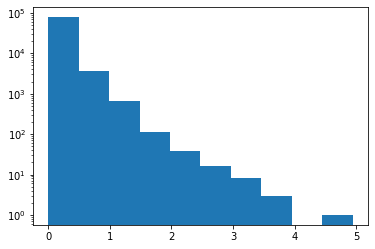

In [52]:
# how many authors have more than a few posts?
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
author_var = 'user_screen_name'
author_post_counts = loanword_post_data.loc[:, author_var].value_counts()
plt.hist(np.log(author_post_counts))
plt.yscale('log')
plt.show()

Most people only use a few loanwords.

In [53]:
min_count = 5
freq_authors = author_post_counts[author_post_counts >= min_count].index.tolist()
print('%d authors with >=%d counts'%(len(freq_authors), min_count))

181 authors with >=5 counts


In [54]:
# get estimates for all authors, assign rare authors to RARE bin
freq_author_var = f'freq_{author_var}'
loanword_post_data = loanword_post_data.assign(**{
    freq_author_var : loanword_post_data.loc[:, author_var].apply(lambda x: x if x in freq_authors else 'RARE_AUTHOR')
})

Maybe this is enough? Let's test it out.

In [55]:
import numpy as np
from scipy.stats import norm, chi
from scipy.sparse import diags, csr_matrix, linalg
## regression helpers
## for GLM type regression
def compute_err_data(model_results):
    """
    Compute error data for regularized regression.
    """
    exog_names = model_results.model.exog_names
    design_mat = model_results.model.exog
    pred_probs = model_results.model.predict(model_results.params)
    # need sparse matrix! to avoid memory explosion
    prob_mat = diags(pred_probs, 0).tocsr()
    design_mat = csr_matrix(design_mat)
    cov_mat = linalg.inv(design_mat.T.dot(prob_mat).dot(design_mat))
    param_err = np.sqrt(np.diag(cov_mat.todense()))
    model_err_data = pd.DataFrame(model_results.params, columns=['mean'])
    model_err_data = model_err_data.assign(**{'SE' : param_err})
    # compute test stat, p-val for two-sided test
    # https://stats.stackexchange.com/questions/60074/wald-test-for-logistic-regression
    model_err_data = model_err_data.assign(**{'z_score' : model_err_data.loc[:, 'mean'] / model_err_data.loc[:, 'SE']})
    # use Wald test
    model_err_data = model_err_data.assign(**{'p_val' : model_err_data.loc[:, 'z_score'].apply(lambda x: 1-chi.cdf(x**2, 1))})
    # model_err_data = model_err_data.assign(**{'p_val' : model_err_data.loc[:, 'z_score'].apply(lambda x: norm.cdf(x))})
    # confidence intervals
    alpha = 0.05
    Z_alpha = norm.ppf(1-alpha/2)
    model_err_data = model_err_data.assign(**{'conf_%.1f'%(alpha/2*100) : model_err_data.loc[:, 'mean'] - Z_alpha*model_err_data.loc[:, 'SE']})
    model_err_data = model_err_data.assign(**{'conf_%.1f'%((1-alpha/2)*100) : model_err_data.loc[:, 'mean'] + Z_alpha*model_err_data.loc[:, 'SE']})
    # model_err_data = model_err_data.assign(**{'p_val' : norm.cdf(model_err_data.loc[:, 't_score'])})
    return model_err_data

In [56]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial
from statsmodels.genmod.families.links import logit
dep_var = 'has_light_verb'
default_author_val = 'RARE_AUTHOR'
formula = f'{dep_var} ~ C({freq_author_var}, Treatment("{default_author_val}"))'
# elastic net regularization => L2 norm more reliable??
# l2_weight = 0.1
# max_iter = 100
# model = GLM.from_formula(formula, freq_author_loanword_post_data, family=Binomial(link=logit()))
# fit_model = model.fit_regularized(maxiter=max_iter, method='elastic_net', alpha=l2_weight, L1_wt=0.0)
# fit_model_results = compute_err_data(fit_model)
# display(fit_model_results)
# boring logit
model = Logit.from_formula(formula, data=loanword_post_data)
fit_model = model.fit_regularized(method='l1')
# fit_model = model.fit(method='bfgs', maxiter=100)
display(fit_model.summary())
# anyone with low p-value?
# p_val_upper = 0.05
# display(fit_model_results[fit_model_results.loc[:, 'p_val'] <= p_val_upper])

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6108778149199134
            Iterations: 176
            Function evaluations: 178
            Gradient evaluations: 176


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         has_light_verb   No. Observations:                89556
Model:                          Logit   Df Residuals:                    89374
Method:                           MLE   Df Model:                          181
Date:                Sun, 03 May 2020   Pseudo R-squ.:                 0.01485
Time:                        12:29:51   Log-Likelihood:                -54708.
converged:                       True   LL-Null:                       -55532.
Covariance Type:            nonrobust   LLR p-value:                5.442e-235
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                -0.7881      0.007   -108.283      0.000      -0.802      -0.774
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T._iamfrederick]       0.3766      0.913      0.412      0.680      -1.414       2.167
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.abcinformes]        -8.0546     31.455     -0.256      0.798     -69.705      53.596
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.agendaonline]       -8.1386     30.684     -0.265      0.791     -68.277      52.000
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.aguilascibaenas]    -8.1386     30.684     -0.265      0.791     -68.277      52.000
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.alejasuarezp]       -7.8467     33.544     -0.234      0.815     -73.592      57.899
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.altamirana2]        -0.7408      1.169     -0.634      0.526      -3.032       1.550
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.anteldetodos]       -8.2551     30.664     -0.269      0.788     -68.355      51.845
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.aotec_es]           -7.9731     32.618     -0.244      0.807     -71.903      55.957
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.applenoticias]      -8.2551     30.664     -0.269      0.788     -68.355      51.845
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.apunteindicado]     -7.9731     32.618     -0.244      0.807     -71.903      55.957
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.areaeditorial]      -8.1386     30.684     -0.265      0.791     -68.277      52.000
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.arnetonline]         1.0750      0.540      1.990      0.047       0.016       2.134
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.astridraga]         -8.0546     31.455     -0.256      0.798     -69.705      53.596
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.attmxayuda]         22.4797   1.28e+04      0.002      0.999   -2.51e+04    2.52e+04
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.ayudaizzi]           0.0941      0.866      0.109      0.913      -1.604       1.792
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.bnc_corporativo]     3.0044      1.013      2.966      0.003       1.019       4.989
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.botnormal24]        -7.9731     32.618     -0.244      0.807     -71.903      55.957
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.cablefibertel]       4.3371      1.011      4.289      0.000       2.355       6.319
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.calumvalentines]    -8.1386     30.684     -0.265      0.791     -68.277      52.000
C(freq_user_screen_name, Treatment("RARE_AUTHOR"))[T.canalcapital] 

OK! So we don't see any strong effects at the per-author level.

TODO: transfer parameters to normal model.

In [ ]:
# load data
loanword_post_social_data = pd.read_csv('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', sep='\t')


### Predict loanword and native word use: filter on media sharing

Let's now only look at authors who shared more than 1 link with a relevant genre.

In [74]:
import pandas as pd
loanword_social_data = pd.read_csv('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', sep='\t')
native_verb_social_data = pd.read_csv('../../data/mined_tweets/native_verbs_post_social_data.tsv', sep='\t')

In [75]:
# add zero vals for scalar media vars
count_media_vars = ['total_video_count', 'latin_american_artist_video_count', 'us_american_artist_video_count', 
                    'total_music_count', 'latin_american_music_genre_count', 'us_american_music_genre_count',
                    'latin_american_media_count', 'us_american_media_count']
for count_media_var in count_media_vars:
    loanword_social_data.fillna({count_media_var : 0}, inplace=True)
    native_verb_social_data.fillna({count_media_var : 0}, inplace=True)

In [76]:
import numpy as np
# log-transform percent data
scalar_vars = ['latin_american_media_pct', 'integrated_verb_pct']
smooth_val = 1e-3

for scalar_var in scalar_vars:
    loanword_social_data = loanword_social_data.assign(**{
        f'log_{scalar_var}' : loanword_social_data.loc[:, scalar_var].apply(lambda x: np.log(x+smooth_val) if type(x) is float else '')
    })
    native_verb_social_data = native_verb_social_data.assign(**{
        f'log_{scalar_var}' : native_verb_social_data.loc[:, scalar_var].apply(lambda x: np.log(x+smooth_val) if type(x) is float else '')
    })

In [77]:
# add dep var
dep_var = 'has_light_verb'
loanword_social_data = loanword_social_data.assign(**{
    dep_var : (loanword_social_data.loc[:, 'loanword_type']=='light_verb_loanword').astype(int)
})
native_verb_social_data = native_verb_social_data.assign(**{
    dep_var : (native_verb_social_data.loc[:, 'native_word_category']=='native_light_verb').astype(int)
})

In [78]:
loanword_social_data.fillna('', inplace=True)
native_verb_social_data.fillna('', inplace=True)
# combined media count
loanword_social_data = loanword_social_data.assign(**{
    'total_media_count' : loanword_social_data.loc[:, 'total_video_count'] + loanword_social_data.loc[:, 'total_music_count']
})
native_verb_social_data = native_verb_social_data.assign(**{
    'total_media_count' : native_verb_social_data.loc[:, 'total_video_count'] + native_verb_social_data.loc[:, 'total_music_count']
})

In [79]:
def filter_valid_data(data, 
                      social_vars=['es_bin', 'latin_american_media_pct', 'description_location_region', 'integrated_verb_pct'],
                      scalar_vars = ['latin_american_media_pct', 'integrated_verb_pct']):
    valid_data = data.copy()
    for social_var in social_vars:
        valid_data = valid_data[valid_data.loc[:, social_var] != '']
    # fix scalar vars
    for scalar_var in scalar_vars:
        valid_data = valid_data.assign(**{
            scalar_var : valid_data.loc[:, scalar_var].astype(float)
        })
    return valid_data

In [80]:
valid_loanword_social_data = filter_valid_data(loanword_social_data)
valid_native_verb_social_data = filter_valid_data(native_verb_social_data)

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [81]:
valid_media_loanword_social_data = valid_loanword_social_data[(valid_loanword_social_data.loc[:, 'latin_american_media_count'] > 1) | 
                                                              (valid_loanword_social_data.loc[:, 'us_american_media_count'] > 1)]
valid_media_native_verb_social_data = valid_native_verb_social_data[(valid_native_verb_social_data.loc[:, 'latin_american_media_count'] > 1) | 
                                                                    (valid_native_verb_social_data.loc[:, 'us_american_media_count'] > 1)]
print('%d/%d loanword data with at least one media link'%(valid_media_loanword_social_data.shape[0], loanword_social_data.shape[0]))
print('%d/%d native verb data with at least one media link'%(valid_media_native_verb_social_data.shape[0], native_verb_social_data.shape[0]))

2059/87610 loanword data with at least one media link
44484/328651 native verb data with at least one media link


OK! This should be enough to start with.

Let's look at loanwords first.

In [82]:
# limit to frequent words
def label_rare_data_var(data, data_var='user_screen_name', min_count=5):
    data_var_counts = data.loc[:, data_var].value_counts()
    freq_data_vals = set(data_var_counts[data_var_counts >= min_count].index.tolist())
    freq_data_var = f'freq_{data_var}'
    data = data.assign(**{
        freq_data_var : data.loc[:, data_var].apply(lambda x: x if x in freq_data_vals else 'RARE')
    })
    return data

In [83]:
min_count = 5
freq_valid_media_loanword_social_data = label_rare_data_var(valid_media_loanword_social_data, data_var='loanword', min_count=min_count)
freq_valid_media_native_verb_social_data = label_rare_data_var(valid_media_native_verb_social_data, data_var='native_word_type', min_count=min_count)

In [84]:
# fix scalar vars
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scalar_vars = ['log_latin_american_media_pct', 'log_integrated_verb_pct']
for scalar_var in scalar_vars:
    freq_valid_media_loanword_social_data = freq_valid_media_loanword_social_data.assign(**{
        scalar_var : scaler.fit_transform(freq_valid_media_loanword_social_data.loc[:, scalar_var].values.reshape(-1,1))
    })
    freq_valid_media_native_verb_social_data = freq_valid_media_native_verb_social_data.assign(**{
        scalar_var : scaler.fit_transform(freq_valid_media_native_verb_social_data.loc[:, scalar_var].values.reshape(-1,1))
    })

In [85]:
## same regression, with subset of media data
from statsmodels.discrete.discrete_model import Logit
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import get_regression_output
binary_dep_var = 'has_light_verb'
media_vars = ['log_latin_american_media_pct']
native_verb_var = 'log_integrated_verb_pct'
scalar_vars = [native_verb_var] + media_vars
lang_bin_var = 'es_bin'
loc_var = 'description_location_region'
word_type_var = 'loanword'
# get default word type val: least frequent
default_word_type_val = freq_valid_media_loanword_social_data.loc[:, word_type_var].value_counts().index[-1]
cat_vars = [lang_bin_var, loc_var, word_type_var]
cat_var_treatment_vals = ['es_high', 'other', default_word_type_val]
scalar_var_str = ' + '.join(scalar_vars)
cat_var_str = ' + '.join(list(map(lambda x: 'C(%s, Treatment("%s"))'%(x[0], x[1]), zip(cat_vars, cat_var_treatment_vals))))
formula = f'{binary_dep_var} ~ {scalar_var_str} + {cat_var_str}'
model = Logit.from_formula(formula, data=freq_valid_media_loanword_social_data)
fit_model = model.fit(method='bfgs', maxiter=1000)
display(fit_model.summary())
# remove all words
fit_model_output = get_regression_output(fit_model)
fit_model_output = fit_model_output.loc[list(filter(lambda x: 'loanword' not in x, fit_model_output.index)), :]
display(fit_model_output)

Optimization terminated successfully.
         Current function value: 0.284294
         Iterations: 385
         Function evaluations: 387
         Gradient evaluations: 387


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         has_light_verb   No. Observations:                 2059
Model:                          Logit   Df Residuals:                     1965
Method:                           MLE   Df Model:                           93
Date:                Wed, 06 May 2020   Pseudo R-squ.:                  0.5457
Time:                        00:10:09   Log-Likelihood:                -585.36
converged:                       True   LL-Null:                       -1288.5
Covariance Type:            nonrobust   LLR p-value:                1.880e-233
=======================================================================================================================================
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               9.6052        nan        nan        nan         nan         nan
C(es_bin, Treatment("es_high"))[T.es_low]                               1.8707        nan        nan        nan         nan         nan
C(es_bin, Treatment("es_high"))[T.es_mid]                              -0.0922        nan        nan        nan         nan         nan
C(description_location_region, Treatment("other"))[T.europe]            0.4642        nan        nan        nan         nan         nan
C(description_location_region, Treatment("other"))[T.latin_america]    -0.2096        nan        nan        nan         nan         nan
C(description_location_region, Treatment("other"))[T.us_america]        0.2929        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.DM]                                 31.9662        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.access]                            -10.2870        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.audit]                             -23.5204        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.ban]                               -24.5402        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.block]                              -6.4105        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.box]                                -9.8291        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.boycott]                            -9.6155        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.bully]                              -9.0538        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.cast]                               -9.4423        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.chat]                              -10.4910        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.check]                             -11.7743        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.connect]                           -12.7606        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.crack]                              -9.1354        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.customize]                         -21.5996        nan        nan        nan         nan         nan
C(loanword, Treatment("delete"))[T.default]                            -9.4447        nan        nan        nan  

,coeff,p,CI_low,CI_high
Intercept,9.605,NaN,NaN,NaN
"C(es_bin, Treatment(""es_high""))[T.es_low]",1.871,NaN,NaN,NaN
"C(es_bin, Treatment(""es_high""))[T.es_mid]",-0.092,NaN,NaN,NaN
"C(description_location_region, Treatment(""other""))[T.europe]",0.464,NaN,NaN,NaN
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.210,NaN,NaN,NaN
"C(description_location_region, Treatment(""other""))[T.us_america]",0.293,NaN,NaN,NaN
log_integrated_verb_pct,0.072,NaN,NaN,NaN
log_latin_american_media_pct,0.008,NaN,NaN,NaN


In [86]:
## same regression, with subset of media data
from statsmodels.discrete.discrete_model import Logit
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import get_regression_output
binary_dep_var = 'has_light_verb'
media_vars = ['latin_american_media_pct']
scalar_vars = [] + media_vars
lang_bin_var = 'es_bin'
loc_var = 'description_location_region'
word_type_var = 'native_word_type'
# get default word type val: least frequent
default_word_type_val = freq_valid_media_native_verb_social_data.loc[:, word_type_var].value_counts().index[-1]
cat_vars = [lang_bin_var, loc_var, word_type_var]
cat_var_treatment_vals = ['es_high', 'other', default_word_type_val]
scalar_var_str = ' + '.join(scalar_vars)
cat_var_str = ' + '.join(list(map(lambda x: 'C(%s, Treatment("%s"))'%(x[0], x[1]), zip(cat_vars, cat_var_treatment_vals))))
formula = f'{binary_dep_var} ~ {scalar_var_str} + {cat_var_str}'
model = Logit.from_formula(formula, data=freq_valid_media_native_verb_social_data)
fit_model = model.fit(method='bfgs', maxiter=1000)
display(fit_model.summary())
# remove all words
fit_model_output = get_regression_output(fit_model)
fit_model_output = fit_model_output.loc[list(filter(lambda x: 'native_word_type' not in x, fit_model_output.index)), :]
display(fit_model_output)

Optimization terminated successfully.
         Current function value: 0.097932
         Iterations: 253
         Function evaluations: 254
         Gradient evaluations: 254


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         has_light_verb   No. Observations:                44484
Model:                          Logit   Df Residuals:                    44431
Method:                           MLE   Df Model:                           52
Date:                Wed, 06 May 2020   Pseudo R-squ.:                  0.4404
Time:                        00:11:23   Log-Likelihood:                -4356.4
converged:                       True   LL-Null:                       -7784.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================================================
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              -2.6364      2.389     -1.104      0.270      -7.318       2.046
C(es_bin, Treatment("es_high"))[T.es_low]                               0.4764      0.791      0.602      0.547      -1.074       2.027
C(es_bin, Treatment("es_high"))[T.es_mid]                              -0.2827      0.142     -1.985      0.047      -0.562      -0.004
C(description_location_region, Treatment("other"))[T.europe]            0.4143      0.114      3.642      0.000       0.191       0.637
C(description_location_region, Treatment("other"))[T.latin_america]    -0.1191      0.065     -1.820      0.069      -0.247       0.009
C(description_location_region, Treatment("other"))[T.us_america]       -0.1754      0.235     -0.746      0.456      -0.636       0.285
C(native_word_type, Treatment("amistar"))[T.admirar]                   -2.4481      2.624     -0.933      0.351      -7.590       2.694
C(native_word_type, Treatment("amistar"))[T.animar]                    -0.2287      2.402     -0.095      0.924      -4.937       4.480
C(native_word_type, Treatment("amistar"))[T.anotar]                     1.9364      2.392      0.810      0.418      -2.752       6.625
C(native_word_type, Treatment("amistar"))[T.aterrizar]                 -2.8134      2.887     -0.974      0.330      -8.473       2.846
C(native_word_type, Treatment("amistar"))[T.bromear]                    2.3383      2.405      0.972      0.331      -2.375       7.052
C(native_word_type, Treatment("amistar"))[T.burlar]                    -0.8826      2.431     -0.363      0.717      -5.647       3.882
C(native_word_type, Treatment("amistar"))[T.castigar]                  -2.9771      2.899     -1.027      0.304      -8.659       2.705
C(native_word_type, Treatment("amistar"))[T.comprar]                   -2.5198      2.396     -1.052      0.293      -7.216       2.176
C(native_word_type, Treatment("amistar"))[T.copiar]                    -1.4106      2.430     -0.580      0.562      -6.174       3.353
C(native_word_type, Treatment("amistar"))[T.cosquillar]                 7.0028      3.407      2.055      0.040       0.325      13.681
C(native_word_type, Treatment("amistar"))[T.culpar]                     1.7827      2.392      0.745      0.456      -2.906       6.471
C(native_word_type, Treatment("amistar"))[T.dañar]                      3.0924      2.390      1.294      0.196      -1.592       7.777
C(native_word_type, Treatment("amistar"))[T.decidir]                    0.0118      2.391      0.005      0.996      -4.674       4.697
C(native_word_type, Treatment("amistar"))[T.disculpar]                  3.2031      2.390      1.340      0.180      -1.482       7.888
C(native_word_type, Treatment("amistar"))[T.duchar]                    -0.1348      2.462     -0.055      0.956  

,coeff,p,CI_low,CI_high
Intercept,-2.636,2.697e-01,-7.318,2.046
"C(es_bin, Treatment(""es_high""))[T.es_low]",0.476,5.470e-01,-1.074,2.027
"C(es_bin, Treatment(""es_high""))[T.es_mid]",-0.283,4.715e-02,-0.562,-0.004
"C(description_location_region, Treatment(""other""))[T.europe]",0.414,2.704e-04,0.191,0.637
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.119,6.883e-02,-0.247,0.009
"C(description_location_region, Treatment(""other""))[T.us_america]",-0.175,4.555e-01,-0.636,0.285
latin_american_media_pct,-0.062,4.816e-01,-0.236,0.111


Among people who share media often, no strong correlation with relevant variables except for native verb use:
- Europe location authors use light verbs more.

### Predict using media balanced data
We have recomputed the media sharing stats using balanced data, i.e. all genres of music have a similar age distribution. 
Does this change the overall results?

We'll use the same setup as before: elastic net regression, all variables.

In [121]:
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import load_clean_data
loanword_post_social_data = load_clean_data('../../data/mined_tweets/loanword_verbs_media_balanced_post_social_data.tsv', rare_control_vars=['loanword', 'screen_name'], data_type='loanword')
native_verb_post_social_data = load_clean_data('../../data/mined_tweets/native_verbs_media_balanced_post_social_data.tsv', rare_control_vars=['native_word_type', 'screen_name'], data_type='native_verb')
print('%d loanword data'%(loanword_post_social_data.shape[0]))
print('%d native verb data'%(native_verb_post_social_data.shape[0]))

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


1227 loanword data
25828 native verb data


Very small but worth a try!!

Loanwords first.

In [118]:
import model_helpers
reload(model_helpers)
from model_helpers import run_regularized_regression
dep_var = 'has_light_verb'
cat_vars = ['freq_loanword', 'freq_screen_name', 'es_bin', 'latin_american_media_pct_bin', 'description_location_region']
cat_var_treatment_vals = ['RARE', 'RARE', 'es_low', 'media_low', 'other']
scalar_vars = ['log_integrated_verb_pct']
model, model_results = run_regularized_regression(loanword_post_social_data, dep_var, scalar_vars=scalar_vars, cat_vars=cat_vars, cat_var_treatment_vals=cat_var_treatment_vals, l2_weight=0.1, max_iter=1000, verbose=False)

In [119]:
display(model_results.loc[list(filter(lambda x: 'freq_loanword' not in x and 'freq_screen_name' not in x, model_results.index.values)), :])
# only significant results
p_val_upper = 0.05
display(model_results[model_results.loc[:, 'p'] <= p_val_upper])

,mean,SE,Z,p,CI_lower,CI_upper
Intercept,-0.319,0.694,-0.459,8.329e-01,-1.679,1.042
"C(es_bin, Treatment(""es_low""))[T.es_high]",-0.302,0.658,-0.459,8.330e-01,-1.591,0.987
"C(es_bin, Treatment(""es_low""))[T.es_mid]",-0.021,0.673,-0.032,9.992e-01,-1.340,1.297
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",-0.067,0.115,-0.588,7.300e-01,-0.292,0.157
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_mid]",-0.110,0.137,-0.809,5.132e-01,-0.378,0.157
"C(description_location_region, Treatment(""other""))[T.europe]",-0.011,0.218,-0.052,9.978e-01,-0.438,0.415
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.087,0.115,-0.754,5.695e-01,-0.312,0.139
"C(description_location_region, Treatment(""other""))[T.us_america]",0.022,0.279,0.077,9.952e-01,-0.524,0.567
log_integrated_verb_pct,0.101,0.053,1.916,2.427e-04,-0.002,0.205


,mean,SE,Z,p,CI_lower,CI_upper
"C(freq_loanword, Treatment(""RARE""))[T.like]",0.380,0.269,1.410,4.678e-02,-0.148,0.908
log_integrated_verb_pct,0.101,0.053,1.916,2.427e-04,-0.002,0.205


OK! After multiple correction we see only weak effects.

- People who use more integrated native verbs tend to use more light verbs

Native verbs.

In [120]:
dep_var = 'has_light_verb'
cat_vars = ['freq_native_word_type', 'freq_screen_name', 'es_bin', 'latin_american_media_pct_bin', 'description_location_region']
cat_var_treatment_vals = ['RARE', 'RARE', 'es_low', 'media_low', 'other']
scalar_vars = []
model, model_results = run_regularized_regression(native_verb_post_social_data, dep_var, scalar_vars=scalar_vars, cat_vars=cat_vars, cat_var_treatment_vals=cat_var_treatment_vals, l2_weight=0.1, max_iter=1000, verbose=False)
display(model_results.loc[list(filter(lambda x: 'freq_native_word_type' not in x and 'freq_screen_name' not in x, model_results.index.values)), :])
# only significant results
p_val_upper = 0.05
display(model_results[model_results.loc[:, 'p'] <= p_val_upper])

,mean,SE,Z,p,CI_lower,CI_upper
Intercept,-0.893,2.136,-0.418,0.861,-5.080,3.294
"C(es_bin, Treatment(""es_low""))[T.es_high]",-0.784,0.908,-0.864,0.456,-2.563,0.995
"C(es_bin, Treatment(""es_low""))[T.es_mid]",-0.108,0.855,-0.126,0.987,-1.784,1.568
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_high]",-0.222,0.641,-0.346,0.904,-1.478,1.034
"C(latin_american_media_pct_bin, Treatment(""media_low""))[T.media_mid]",-0.163,0.969,-0.168,0.977,-2.062,1.735
"C(description_location_region, Treatment(""other""))[T.europe]",-0.043,0.876,-0.049,0.998,-1.761,1.674
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.246,0.601,-0.410,0.867,-1.423,0.931
"C(description_location_region, Treatment(""other""))[T.us_america]",-0.027,1.581,-0.017,1.000,-3.126,3.071


,mean,SE,Z,p,CI_lower,CI_upper


No significant effects! Awesome.

### Predict with author subset: highly active authors
What happens if we restrict our analysis to only authors who are highly active, i.e. consistent light verb authors vs. consistent integrated verb authors? We'll use the loanword and native verb data to determine consistent use authors.

In [126]:
# # load data
loanword_verb_data = pd.read_csv('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', sep='\t')
native_verb_data = pd.read_csv('../../data/mined_tweets/native_verbs_post_social_data.tsv', sep='\t')
combined_verb_data = pd.concat([loanword_verb_data, native_verb_data], axis=0)
print(combined_verb_data.loc[:, 'has_light_verb'].value_counts())

0    374299
1     41962
Name: has_light_verb, dtype: int64


In [176]:
# restrict to authors with consistent posts 
min_count = 5
author_var = 'screen_name'
author_counts = combined_verb_data.loc[:, author_var].value_counts()
freq_authors = author_counts[author_counts >= min_count].index.tolist()
dep_var = 'has_light_verb'
light_verb_pct = combined_verb_data.groupby(author_var).apply(lambda x: x.loc[:, dep_var].mean())
light_verb_pct = light_verb_pct[light_verb_pct.index.isin(freq_authors)]
verb_use_upper = 0.6
verb_use_lower = 0.4
light_verb_authors = light_verb_pct[light_verb_pct >= verb_use_upper].index.tolist()
integrated_verb_authors = light_verb_pct[light_verb_pct <= verb_use_upper].index.tolist()
print('%d light verb authors; %d integrated verb authors'%(len(light_verb_authors), len(integrated_verb_authors)))

68 light verb authors; 14021 integrated verb authors


First let's compare aggregate social attributes.

In [177]:
author_social_data = pd.read_csv('../../data/mined_tweets/loanword_authors_combined_balanced_media_full_social_data.tsv', sep='\t')
author_social_data.fillna('', inplace=True)
light_verb_author_social_data = author_social_data[author_social_data.loc[:, author_var].isin(light_verb_authors)]
integrated_verb_author_social_data = author_social_data[author_social_data.loc[:, author_var].isin(integrated_verb_authors)]

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [178]:
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
# compare distributions
# chi-2 test for categorical variables
cat_vars = ['description_location_region']
for cat_var_i in cat_vars:
    light_verb_author_data_i = light_verb_author_social_data[light_verb_author_social_data.loc[:, cat_var_i]!=''].loc[:, cat_var_i]
    integrated_verb_author_data_i = integrated_verb_author_social_data[integrated_verb_author_social_data.loc[:, cat_var_i]!=''].loc[:, cat_var_i]
#     print(light_verb_author_data_i.value_counts())
#     print(integrated_verb_author_data_i.value_counts())
    contingency_table_i = pd.concat([light_verb_author_data_i.value_counts(), integrated_verb_author_data_i.value_counts()], axis=1).fillna(0, inplace=False)
    contingency_table_i.columns = ['light_verb_authors', 'integrated_verb_authors']
    norm_contingency_table_i = contingency_table_i / contingency_table_i.sum(axis=0)
    print(norm_contingency_table_i)
    test_stat, p_val, dof, expected = chi2_contingency(contingency_table_i)
    print('var={%s} has different distributions with test stat %.3f (p=%.3E)'%(cat_var_i, test_stat, p_val))
    # combine, reorganize into contingency table
# Mann-Whitney for scalar variables
scalar_vars = ['es', 'integrated_verb_pct', 'latin_american_media_pct']
smooth_val = 1e-2
for scalar_var_i in scalar_vars:
    light_verb_author_data_i = light_verb_author_social_data[light_verb_author_social_data.loc[:, scalar_var_i]!=''].loc[:, scalar_var_i].astype(float)
    integrated_verb_author_data_i = integrated_verb_author_social_data[integrated_verb_author_social_data.loc[:, scalar_var_i]!=''].loc[:, scalar_var_i].astype(float)
    # log-scale
#     light_verb_author_data_i = np.log(light_verb_author_data_i + smooth_val)
#     integrated_verb_author_data_i = np.log(integrated_verb_author_data_i + smooth_val)
    # compute median
    print('var={%s} has (light verb author) median %.3f and (integrated verb author) median %.3f'%
          (scalar_var_i, np.median(light_verb_author_data_i), np.median(integrated_verb_author_data_i)))
    test_i = mannwhitneyu(light_verb_author_data_i.values, integrated_verb_author_data_i.values)
    print('var={%s} has different distributions with test stat %.3f (p=%.3E)'%(scalar_var_i, test_i.statistic, test_i.pvalue))

               light_verb_authors  integrated_verb_authors
latin_america               0.519                    0.348
other                       0.370                    0.547
europe                      0.111                    0.077
us_america                  0.000                    0.028
var={description_location_region} has different distributions with test stat 9.827 (p=2.009E-02)
var={es} has (light verb author) median 1.000 and (integrated verb author) median 0.949
var={es} has different distributions with test stat 210000.000 (p=3.681E-16)
var={integrated_verb_pct} has (light verb author) median 0.667 and (integrated verb author) median 1.000
var={integrated_verb_pct} has different distributions with test stat 146252.000 (p=2.168E-19)
var={latin_american_media_pct} has (light verb author) median 1.000 and (integrated verb author) median 0.333
var={latin_american_media_pct} has different distributions with test stat 205.000 (p=1.019E-01)


OK! We see that:

- light verb authors have different locations from integrated verb authors (more Latin America?)
- light verb authors use higher rate of Spanish than integrated verb authors
- light verb authors use lower rate of verb integration
- no conclusion about media because data sparsity

Does this hold up in a regression?

Note: we tried this with the media variable and found no effect for any variable, as shown before.

In [202]:
from model_helpers import load_clean_data
# let's limit to the more dense variables just to be safe
filter_vars = ['es_bin', 'description_location_region', 'integrated_verb_pct']
scalar_vars = ['integrated_verb_pct']
loanword_post_social_data = load_clean_data('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', rare_control_vars=['loanword', 'screen_name'], data_type='loanword', filter_vars=filter_vars, scalar_vars=scalar_vars)
filter_vars = ['es_bin', 'description_location_region']
scalar_vars = []
native_verb_post_social_data = load_clean_data('../../data/mined_tweets/native_verbs_post_social_data.tsv', rare_control_vars=['native_word_type', 'screen_name'], data_type='native_verb', filter_vars=filter_vars, scalar_vars=scalar_vars)

In [203]:
author_var = 'screen_name'
relevant_authors = set(light_verb_authors) | set(integrated_verb_authors)
print(len(relevant_authors))
relevant_author_loanword_post_social_data = loanword_post_social_data[loanword_post_social_data.loc[:, author_var].isin(relevant_authors)]
relevant_author_native_verb_post_social_data = native_verb_post_social_data[native_verb_post_social_data.loc[:, author_var].isin(relevant_authors)]
print(relevant_author_loanword_post_social_data.shape[0])
print(relevant_author_native_verb_post_social_data.shape[0])

14071
13220
226044


Let's roll!!

Loanword light verb prediction.

In [204]:
import model_helpers
reload(model_helpers)
from model_helpers import run_regularized_regression
dep_var = 'has_light_verb'
cat_vars = ['freq_loanword', 'freq_screen_name', 'es_bin', 'description_location_region']
cat_var_treatment_vals = ['RARE', 'RARE', 'es_low', 'other']
scalar_vars = ['log_integrated_verb_pct']
model, model_results = run_regularized_regression(relevant_author_loanword_post_social_data, dep_var, scalar_vars=scalar_vars, cat_vars=cat_vars, cat_var_treatment_vals=cat_var_treatment_vals, l2_weight=0.1, max_iter=1000, verbose=False)

In [205]:
display(model_results.loc[list(filter(lambda x: 'freq_loanword' not in x and 'freq_screen_name' not in x, model_results.index.values)), :])

,mean,SE,Z,p,CI_lower,CI_upper
Intercept,-0.394,0.610,-0.646,6.763e-01,-1.589,0.801
"C(es_bin, Treatment(""es_low""))[T.es_high]",-0.401,0.400,-1.002,3.150e-01,-1.184,0.383
"C(es_bin, Treatment(""es_low""))[T.es_mid]",0.006,0.406,0.015,9.998e-01,-0.789,0.801
"C(description_location_region, Treatment(""other""))[T.europe]",-0.088,0.065,-1.348,6.904e-02,-0.215,0.040
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.087,0.037,-2.350,3.329e-08,-0.159,-0.014
"C(description_location_region, Treatment(""other""))[T.us_america]",-0.023,0.100,-0.231,9.575e-01,-0.219,0.173
log_integrated_verb_pct,-0.064,0.025,-2.553,7.230e-11,-0.113,-0.015


OK! So we replicate the findings from earlier, except without the language effect.

In [207]:
import model_helpers
reload(model_helpers)
from model_helpers import run_regularized_regression
dep_var = 'has_light_verb'
cat_vars = ['freq_native_word_type', 'freq_screen_name', 'es_bin', 'description_location_region']
native_word_type_treatment_val = relevant_author_native_verb_post_social_data.loc[:, 'freq_native_word_type'].value_counts().index[0]
cat_var_treatment_vals = [native_word_type_treatment_val, 'RARE', 'es_low', 'other']
scalar_vars = []
model, model_results = run_regularized_regression(relevant_author_native_verb_post_social_data, dep_var, scalar_vars=scalar_vars, cat_vars=cat_vars, cat_var_treatment_vals=cat_var_treatment_vals, l2_weight=0.1, max_iter=1000, verbose=False)

In [208]:
display(model_results.loc[list(filter(lambda x: 'freq_native_word_type' not in x and 'freq_screen_name' not in x, model_results.index.values)), :])

,mean,SE,Z,p,CI_lower,CI_upper
Intercept,-0.895,0.352,-2.544,9.784e-11,-1.585,-0.205
"C(es_bin, Treatment(""es_low""))[T.es_high]",-0.831,0.352,-2.362,2.427e-08,-1.521,-0.141
"C(es_bin, Treatment(""es_low""))[T.es_mid]",-0.063,0.400,-0.158,9.801e-01,-0.848,0.721
"C(description_location_region, Treatment(""other""))[T.europe]",-0.088,0.165,-0.531,7.781e-01,-0.412,0.236
"C(description_location_region, Treatment(""other""))[T.latin_america]",-0.268,0.090,-2.978,0.000e+00,-0.445,-0.092
"C(description_location_region, Treatment(""other""))[T.us_america]",-0.024,0.212,-0.115,9.895e-01,-0.440,0.391


### Old code

In [95]:
import pandas as pd
# load combined data
# loanword_author_social_data = pd.read_csv('../../data/mined_tweets/tweet_loanword_authors_social_data.tsv', sep='\t', index_col=False)
# display(loanword_author_social_data.head())
# if we can't combine...load the data separately
lang_data = pd.read_csv('../../data/mined_tweets/author_LANG=es_pct.tsv', sep='\t', index_col=False)
media_data = pd.read_csv('../../data/mined_tweets/author_media_counts.tsv', sep='\t', index_col=False)
loc_data = pd.read_csv('../../data/mined_tweets/loanword_author_descriptive_data_location_data.tsv', sep='\t', index_col=False)
loc_data.rename(columns={'user_screen_name' : 'screen_name'}, inplace=True)

## convert country to region
latin_american_country_codes = ['AR', 'BO', 'BR', 'CL', 'CO', 'CR', 'CU', 'DO', 'EC', 'SV', 'GT', 'HT', 
                                'HN', 'MX', 'NI', 'PA', 'PY', 'PE', 'PR', 'UY', 'VE']
us_country_codes = ['US']
europe_country_codes = ['ES']
country_region_lookup = {c : 'latin_america' for c in latin_american_country_codes}
country_region_lookup.update({c : 'us_america' for c in us_country_codes})
country_region_lookup.update({c : 'europe' for c in europe_country_codes})
loc_data = loc_data.assign(**{
    'description_location_region' : loc_data.loc[:, 'description_location_country'].apply(country_region_lookup.get)
})
loc_data.fillna('', inplace=True)

## normalize all name data
author_var = 'screen_name'
author_data_list = [lang_data, media_data, loc_data]
clean_author_data_list = []
for author_data_i in author_data_list:
    author_data_i = author_data_i.assign(**{
        author_var : author_data_i.loc[:, author_var].apply(lambda x: x.lower())
    })
    clean_author_data_list.append(author_data_i)
author_data_list = clean_author_data_list

In [96]:
author_data_combined = []
for author_data_i in author_data_list:
    if(len(author_data_combined) == 0):
        author_data_combined = author_data_i.copy()
    else:
        author_data_combined = pd.merge(author_data_combined, author_data_i, on=author_var)
author_data_combined.fillna('', inplace=True)
display(author_data_combined.head())

,es,screen_name,total_link_count,latin_american_genre_count,us_american_genre_count,loanword_type,user_id,user_description,user_location,description_location_country,description_location_region
0,0.455959,08_nick,9,0,4,integrated_loanword,180459760,"Music, art, books, tech, geek, ups, downs, bla...",costa rica,CR,latin_america
1,0.921986,0dweller,12,0,5,integrated_loanword,177279308,"Hello, friend? That's lame. Maybe I should giv...",s14a316,,
2,0.616246,0osman,15,2,10,light_verb_loanword,33029742,Biologist. Britney's fan. Tumblr and music lov...,dreamworks,,
3,0.434084,110_pg,2,0,2,integrated_loanword,3809349923,“I need someone to fill my life with adventure...,"bogota, d.c., colombia",CO,latin_america
4,0.975336,123natitass,1,1,0,light_verb_loanword,1401392642,ACEPTAMOS EL AMOR QUE CREEMOS MERECER,"puente alto, chile",,


### Test location+language
Not many authors have all social factors. What if we restrict to authors who have the more common factors, i.e. language use and location?

In [121]:
limited_author_data_list = [lang_data, loc_data]
limited_social_vars = ['es', 'description_location_region']
limited_author_data_combined = []
for author_data_i in limited_author_data_list:
    if(len(limited_author_data_combined) == 0):
        limited_author_data_combined = author_data_i.copy()
    else:
        limited_author_data_combined = pd.merge(limited_author_data_combined, author_data_i, on=author_var)
limited_author_data_combined.fillna('', inplace=True)
display(limited_author_data_combined.head())
for social_var in limited_social_vars:
    limited_author_data_combined = limited_author_data_combined[limited_author_data_combined.loc[:, social_var] != '']
display(limited_author_data_combined.head())
dep_var = 'loanword_type'
print(limited_author_data_combined.loc[:, dep_var].value_counts())
# clean up vars
# dependent var
dep_var = 'loanword_type'
limited_author_data_combined = limited_author_data_combined.assign(**{
    'has_light_verb' : (limited_author_data_combined.loc[:, dep_var]=='light_verb_loanword').astype(int)
})
# lang category
lang_var = 'es'
lang_var_bins = [0.5, 0.75]
lang_var_bin_lookup = {0 : 'low_bilingual', 1 : 'high_bilingual', 2 : 'monolingual'}
lang_category_var = f'{lang_var}_category'
limited_author_data_combined = limited_author_data_combined.assign(**{
    lang_category_var : list(map(lang_var_bin_lookup.get, np.digitize(limited_author_data_combined.loc[:, lang_var], bins=lang_var_bins)))
})

,es,screen_name,loanword_type,user_id,user_description,user_location,description_location_country,description_location_region
0,0.951779,000822e5bc974e0,integrated_loanword,3265436678,Es legítima la resistencia del pueblo para la ...,guatemala,GT,latin_america
1,0.957014,007martin,integrated_loanword,825201368,"La vida te va enseñando quién sí, quién no y q...",sevilla...,,
2,0.940678,027Cai,integrated_loanword,949403523711631360,☠️,"carolina, puerto rico",,
3,0.948718,02florvargas,light_verb_loanword,999479611946921984,Antes de amar alguien más tengo que amarme. 😌 ...,"zamora, michoacan de ocampo",,
4,0.937500,04Neream,integrated_loanword,996033389735153664,Muyyy a lo mio☁️☁️☁️,espana,ES,europe


/hg190/istewart6/miniconda3/envs/loanword_adoption/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,es,screen_name,loanword_type,user_id,user_description,user_location,description_location_country,description_location_region
0,0.951779,000822e5bc974e0,integrated_loanword,3265436678,Es legítima la resistencia del pueblo para la ...,guatemala,GT,latin_america
4,0.937500,04Neream,integrated_loanword,996033389735153664,Muyyy a lo mio☁️☁️☁️,espana,ES,europe
6,0.939297,04willy,integrated_loanword,401683010,"Quize aportar al conocimiento, pero aqui no se...",guayaquil,EC,latin_america
7,0.294118,0503Laury,integrated_loanword,1591584739,Colombia!🇨🇴 Vkook🇰🇷Yoonmin🇰🇷Namjin🇰🇷ARMY❤️,"bogota, d.c., colombia",CO,latin_america
8,0.943700,05vmar_,light_verb_loanword,1007463880610721797,🇻🇪🔛🇨🇱 | 18yearsold | mi familia es mi vida ent...,"santiago, chile",CL,latin_america


integrated_loanword    1686
light_verb_loanword     559
Name: loanword_type, dtype: int64


Coverage is a little better. Let's try the same thing as before.

In [123]:
from statsmodels.discrete.discrete_model import Logit
binary_dep_var = 'has_light_verb'
scalar_vars = []
cat_vars = [lang_category_var, loc_var]
scalar_var_str = ' + '.join(scalar_vars)
cat_var_str = ' + '.join(list(map(lambda x: f'C({x})', cat_vars)))
formula = f'{binary_dep_var} ~ {scalar_var_str} + {cat_var_str}'
model = Logit.from_formula(formula, data=limited_author_data_combined)
fit_model = model.fit()
display(fit_model.summary())

Optimization terminated successfully.
         Current function value: 0.556942
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         has_light_verb   No. Observations:                 2245
Model:                          Logit   Df Residuals:                     2240
Method:                           MLE   Df Model:                            4
Date:                Tue, 07 Apr 2020   Pseudo R-squ.:                0.007643
Time:                        18:44:27   Log-Likelihood:                -1250.3
converged:                       True   LL-Null:                       -1260.0
Covariance Type:            nonrobust   LLR p-value:                 0.0006984
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -0.3445      0.201     -1.714      0.086      -0.738       0.049
C(es_category)[T.low_bilingual]                    -0.4111      0.269     -1.527      0.127      -0.939       0.117
C(es_category)[T.monolingual]                      -0.7508      0.175     -4.300      0.000      -1.093      -0.409
C(description_location_region)[T.latin_america]    -0.1001      0.129     -0.779      0.436      -0.352       0.152
C(description_location_region)[T.us_america]       -0.1439      0.234     -0.614      0.539      -0.603       0.316
===================================================================================================================
"""

OK! We see a big difference here: monolingual speakers are much less likely to use a light verb. Again, not what we expected from intuitive understanding!